# **RMBA-2771 Fall 2025 — Group B9 Assignment 1**

**Team:** António Marques Dos Santos (71212), Nicolas Oteri (71642) and Simon Anthofer (71078)

**Deadline:** 11 Oct 2025

---
---



# 0 Project Setup

Below, we will
- install any required packages
- import the libraries needed for the project
- upload the **Loan Default** CSV file
- load it into a pandas DataFrame for further exploration.

In [ ]:
# Install any missing packages
#%pip install -q missingno

# Data handling
import numpy as np
import pandas as pd
from google.colab import files
import missingno as msno


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import output; output.enable_custom_widget_manager()
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Statistics
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# ML utilities (for imputation, etc.)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Upload file
uploaded = files.upload()

# Get the first uploaded filename
filename = next(iter(uploaded.keys()))

# Load dataset
df_raw = pd.read_csv(filename, sep=",")

# Basic dataset info
print("Shape (rows, columns):", df_raw.shape)
df_raw.info()

# Preview first 5 rows
df_raw.head(5)

Saving Loan_Default.csv to Loan_Default.csv
Shape (rows, columns): (148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Intere

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0




---

---

# 1 Executive Summary

**Research Goal:**
The study investigates which household and loan characteristics significantly explain variation in debt and how income and creditworthiness interact in shaping borrowing behavior.

**Data Preparation:**
Fields were standardized, total debt was computed as income × DTI, and creditworthiness was harmonized into two categories: L1 (prime, ≈4.03% mean interest) and L2 (subprime, ≈4.48%).

**Method 1 – Baseline OLS Regression (debt ~ income):**

The model produced the equation:

> `debt` = 393.6 + 0.3099 * `income` + e


The income coefficient was β = 0.3099 (95% CI [0.309, 0.311], p < 0.001), explaining R² ≈ 0.713 (71.3%) of the variation in debt.
This confirms income as a dominant and statistically significant driver of household debt.

**Method 1 – Expanded OLS Model (debt ~ income + loan characteristics):**

Incorporating additional variables (loan_amount, rate_of_interest, interest_rate_spread, term, occupancy_type, loan_purpose) increased explanatory power to R² ≈ 0.76.
The updated income effect remained positive and significant (β = 0.2582, p < 0.001), showing that income remains central even after accounting for borrower and loan features.

**Method 2 – Welch Two-Sample t-Test (creditworthiness ~ income):**

A Welch t-test found that L2 households had a slightly higher mean income (6,652 ± 3,844) than L1 (6,408 ± 3,589), a difference of ≈ $244 (95% CI [138, 350]).
The result was statistically significant (t(5652.8) = 4.51, p(one-sided) < 0.001) but small in magnitude (Hedges’ g = 0.07), implying only a modest practical difference (~3.8%).

**Key Takeaway:**

income explains most of the variance in debt (≈71–76%), yet differences by creditworthiness—though statistically significant—are minor in scale.
This suggests that creditworthiness adds explanatory power beyond income, likely capturing behavioral or risk-based factors such as repayment discipline or access to financing.

**Business Implication:**

For lenders and policy teams, income should remain a core predictor for affordability and limit setting, but segmentation by creditworthiness provides valuable additional insight into borrower behavior and risk profiles.



---

---

# 2 Introduction

## **2.1 Dataset & Variables**  
- *Dataset:* Kaggle’s **Loan Default Dataset** (Author: M. Yasser H.)  
- *Primary variables of interest:*  
  - `income`: income of the applicant  
  - `debt`: derived debt measure, calculated from income and debt-to-income ratio  

- *Additional variables included in the dataset:*  
  - `ID`: Unique loan application ID  
  - `year`: Year of the loan application  
  - `loan_limit`: Indicates whether the loan is conforming (`cf`) or non-conforming (`ncf`)  
  - `Gender`: Applicant's gender (male, female, joint, not available)  
  - `approv_in_adv`: Whether the loan was pre-approved (`pre`, `nopre`)  
  - `loan_type`: Type of loan (`type1`, `type2`, `type3`)  
  - `loan_purpose`: Purpose of the loan (`p1`, `p2`, `p3`, `p4`)  
  - `Credit_Worthiness`: Credit worthiness classification (`l1`, `l2`)  
  - `open_credit`: Whether the applicant has open credit accounts (`opc`, `nopc`)  
  - `business_or_commercial`: Indicates if loan is for business/commercial or personal use (`ob/c`, `nob/c`)  
  - `loan_amount`: Total loan amount requested  
  - `rate_of_interest`: Interest rate charged on the loan  
  - `Interest_rate_spread`: Difference from the benchmark interest rate  
  - `Upfront_charges`: Initial charges to secure the loan  
  - `term`: Loan term in months  
  - `Neg_ammortization`: Whether negative amortization is allowed (`neg_amm`, `not_neg`)  
  - `interest_only`: Whether the loan has an interest-only payment option (`int_only`, `not_int`)  
  - `lump_sum_payment`: Requirement for a lump sum payment at the end (`lpsm`, `not_lpsm`)  
  - `property_value`: Appraised value of the financed property  
  - `construction_type`: Type of construction (`site built`, `manufactured home`)  
  - `occupancy_type`: Purpose of property use (`primary`, `secondary`, `investment`)  
  - `Secured_by`: Type of collateral (`home`, `land`)  
  - `total_units`: Number of units in the property (1U–4U)  
  - `credit_type`: Applicant’s credit source (e.g., CIB, CRIF, EXP, EQUI)  
  - `Credit_Score`: Applicant’s credit score  
  - `co-applicant_credit_type`: Credit source of co-applicant (if any)  
  - `age`: Applicant's age  
  - `submission_of_application`: Method of application submission (to institution, not to institution)  
  - `LTV`: Loan-to-Value ratio (loan amount ÷ property value)  
  - `Region`: Geographical region (North, South, Central, North-East)  
  - `Security_Type`: Type of security/collateral (direct, indirect)  
  - `Status`: Loan default status (`1` = defaulted, `0` = not defaulted)  
  - `dtir1`: Debt-to-Income Ratio (used to derive `debt`)  

## **2.2 Research Question & Hypotheses**  

Numerous academic papers have explored the relationship between leverage and corporate profitability. However, household debt is equally relevant — particularly in light of the recent surge in global debt levels and the ongoing lack of consensus regarding the key drivers of this trend. In fact, studies often produce conflicting results, highlighting the need for further empirical investigation (Chikeya & Ntsalaze, 2025).

This assignment aims to contribute to that ongoing academic discourse by investigating — within the limitations of the available data and methods — how household income and debt are interrelated.

A recent study introduced a novel dynamic model to analyze household debt and income variation, focusing on the interplay between financial fragility and financial literacy. The findings suggest that households with lower financial literacy tend to react more procyclically to income shocks, increasing their financial vulnerability (Calcagnini, Favaretto, Giombini, & Tramontana, 2025).

The core research question of this assignment is:

> **Which household and loan characteristics significantly explain variations in the `debt` variable in this dataset?**

**Hypothesis 1:**  
> **Income has a positive and statistically significant effect on `debt`, and remains the primary driver of debt levels even when controlling for other loan and household characteristics (expanded model).**

Prior research demonstrates that the relationship between household borrowing and economic conditions differs sharply across levels of creditworthiness. Prime borrowers typically adjust the composition of their debt without major changes in total indebtedness, whereas less-creditworthy households expand or contract their overall debt more aggressively in response to shifts in credit access and collateral values. This evidence suggests that differences in creditworthiness may influence how households translate income into borrowing behavior, providing the rationale for our second hypothesis (Brown, Stein, & Zafar, 2013). If Hypothesis 1 holds—meaning income significantly explains variation in debt—then differences in income also help explain differences in household indebtedness.

**Hypothesis 2:**  
> **Borrowers with lower creditworthiness have higher mean income than borrowers with higher creditworthiness.**

## **2.3 Analysis Plan**  
- **Data Preparation:** Conduct Exploratory Data Analysis (EDA) and clean the data accordingly.  
- **Method 1:** Conduct an enhanced **linear regression model** with `debt` as the dependent variable and a systematically selected set of numerical and categorical predictors (identified via Cross-Validation and feature selection).  
- **Method 2:** Quantify whether income differs between the two creditworthiness groups (l1 high/prime, l2 low/subprime) through a **two-sample t-test**  

This analysis will help to uncover whether a meaningful relationship exists between income levels, loan characteristics, and household debt in the dataset and if these patterns align with broader theoretical expectations.




---



---



# 3 Exploratory Data Analysis (EDA) with Data Cleaning

 In this section we try to **understand** the data and **prepare** it for analysis. The tables/plots will help visualizing.




## 3.1 Data Quality & Handling Missing Values

Before analysis, it's essential to assess the dataset's quality. Missing or incorrect values can distort results and reduce model accuracy. Therefore, data cleaning is a crucial first step.

### Why is this important?

- **Reliable results:** Incomplete or inconsistent data can lead to biased outcomes.
- **Valid assumptions:** Many methods assume clean, complete data.
- **Transparency:** Clear handling of data quality issues improves reproducibility.


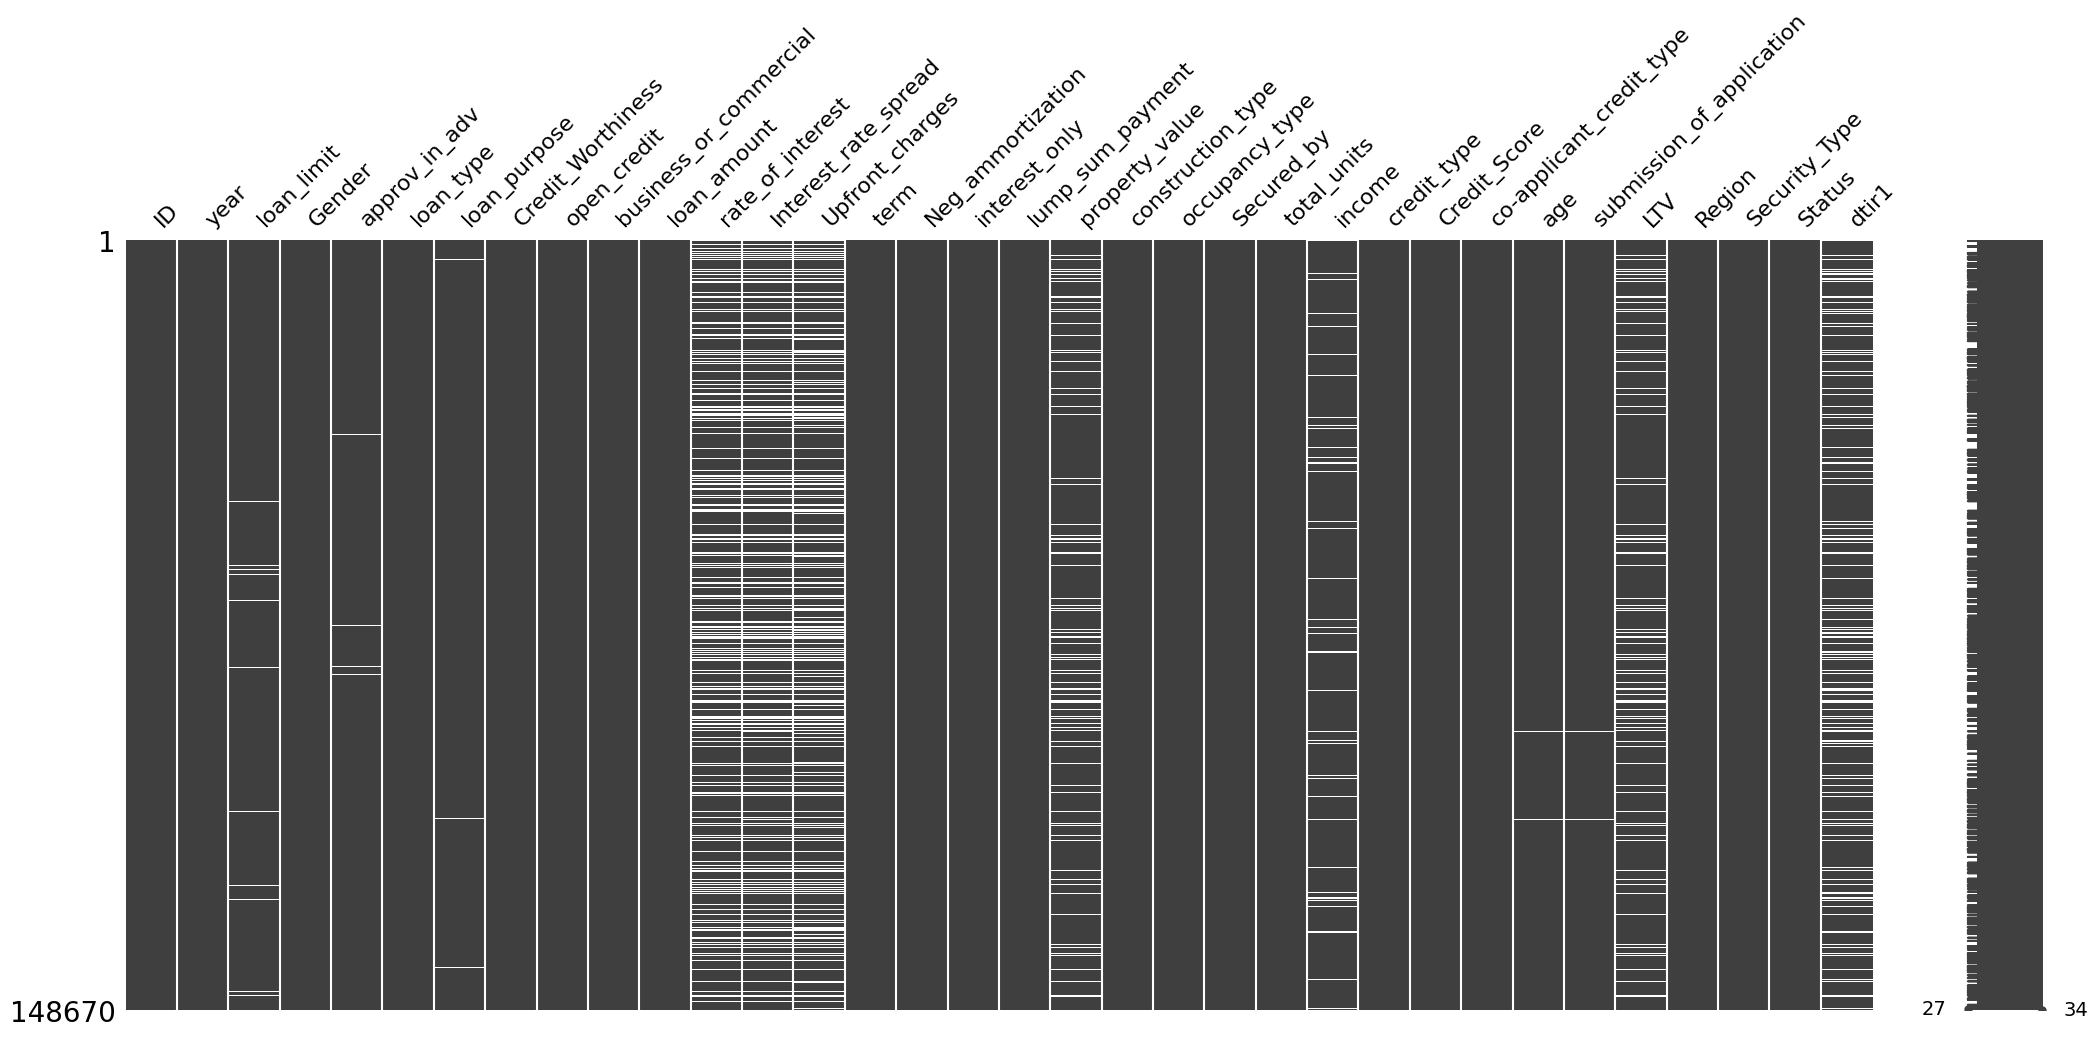

<Figure size 900x500 with 0 Axes>

In [ ]:
# visualize missingness
msno.matrix(df_raw)

# set figure size
plt.figure(figsize=(9,5))

# render plot
plt.show()




**Missingness**: The plot above shows several columns with substantial missing values highlighted in white lines.  


In [ ]:
# normalize: lowercase + trim column names and string values on a safe copy
# Ensure we're safe to modify
df_raw = df_raw.copy()

# column names → strip + lowercase
# 1) Column names: trim + lowercase
df_raw.columns = pd.Index(df_raw.columns).str.strip().str.lower()

# string-like columns → strip + lowercase (NaNs preserved)
# 2) String-like columns: trim + lowercase (preserve NaNs)
obj_like = df_raw.select_dtypes(include=["object", "category"]).columns
for c in obj_like:
    s = df_raw[c].astype("string")  # robust string dtype, keeps NA
    df_raw[c] = s.str.strip().str.lower()

# quick per-column missingness printer (+ return % dict)
# Missing-value summary
def get_missing_summary(df: pd.DataFrame):
    total = len(df)
    missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_cols:
        null_count = df[col].isnull().sum()
        per = (null_count / total) * 100
        missing_percent[col] = per
        print(f"{col}: {null_count} ({per:.3f}%)")
    return missing_percent

# run missingness summary on normalized df
# Show missingness in the raw data
missing_percent = get_missing_summary(df_raw)


loan_limit: 3344 (2.249%)
approv_in_adv: 908 (0.611%)
loan_purpose: 134 (0.090%)
rate_of_interest: 36439 (24.510%)
interest_rate_spread: 36639 (24.645%)
upfront_charges: 39642 (26.664%)
term: 41 (0.028%)
neg_ammortization: 121 (0.081%)
property_value: 15098 (10.155%)
income: 9150 (6.155%)
age: 200 (0.135%)
submission_of_application: 200 (0.135%)
ltv: 15098 (10.155%)
dtir1: 24121 (16.225%)


Above we can find the percentages of the missing values per variable. We can see, that there are quite some.

Summary of missing values:  
*   `income` has ~6% missing
*   `dtir1` has ~16% missing
*    Other variables range from 0% missing values to ~27%

In [ ]:
# copy raw and count missing per row
df_final = df_raw.copy()
df_final["__missing_count"] = df_final.isnull().sum(axis=1)

# log before filtering
print("Samples before removal:", df_final.shape[0])

# keep rows with ≤5 missing; drop helper col; reset index
df_final = (
    df_final[df_final["__missing_count"] <= 5]
    .drop(columns="__missing_count")
    .reset_index(drop=True)
)

# log after filtering
print("Samples after removal:", df_final.shape[0])


Samples before removal: 148670
Samples after removal: 133507


What we did:

- Row-level filtering: We removed rows with more than 5 missing values, because we don't want incomplete data to bias our further analysis and on the other hand we don't want to lose to much information by dropping to many rows. Hence, the threshold of 5 is a good compomise.  
- Dataset reduced from 148,670 to 133,507 rows, which is still a large sample size.  


In [ ]:
# work on a copy of df_final
df_median = df_final.copy()

# get numeric columns
num_cols = df_median.select_dtypes(include="number").columns.tolist()

# fill NaNs in numeric columns with the column median
for col in num_cols:
    median_val = df_median[col].median()
    df_median[col] = df_median[col].fillna(median_val)

# reset index after imputation
df_median = df_median.reset_index(drop=True)

# quick check of remaining missingness
_ = get_missing_summary(df_median)

loan_limit: 2956 (2.214%)
approv_in_adv: 809 (0.606%)
loan_purpose: 109 (0.082%)
neg_ammortization: 113 (0.085%)
age: 144 (0.108%)
submission_of_application: 144 (0.108%)


Above we made use of the median imputation to fill missing numerical values with the columns median. In the summary, we can see that the dataset's missing values are reduced significantly with this approach.

Next step, we control the influence of this imputation approach by comparing the income distribution before and after application.

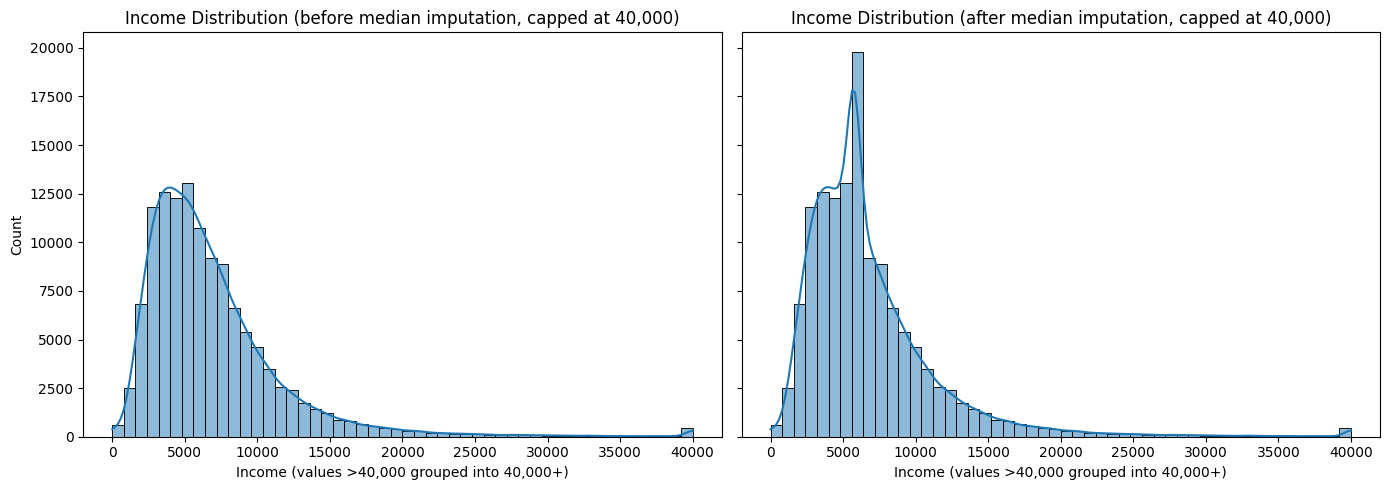

In [ ]:
# compare income distributions before/after imputation (only if column exists)
if "income" in df_final.columns:
    # ensure numeric; coerce invalid to NaN
    before_income = pd.to_numeric(df_final["income"], errors="coerce")
    after_income  = pd.to_numeric(df_median["income"], errors="coerce")

    # cap extreme values for readability
    before_capped = before_income.clip(upper=40000)
    after_capped  = after_income.clip(upper=40000)

    # two side-by-side histograms with shared y-axis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # before imputation
    sns.histplot(before_capped, kde=True, bins=50, ax=axes[0])
    axes[0].set_title("Income Distribution (before median imputation, capped at 40,000)")
    axes[0].set_xlabel("Income (values >40,000 grouped into 40,000+)")

    # after imputation
    sns.histplot(after_capped, kde=True, bins=50, ax=axes[1])
    axes[1].set_title("Income Distribution (after median imputation, capped at 40,000)")
    axes[1].set_xlabel("Income (values >40,000 grouped into 40,000+)")

    # tidy layout and render
    plt.tight_layout()
    plt.show()
else:
    # guard: missing income column
    print("Column 'income' not found in df_final/df_median — skipping the comparison plot.")



- **Issue with Median Imputation:**  
  While median imputation is simple and robust, it **distorts the distribution** of variables as we can see in the histogramms above.  
  In our dataset, all missing `income` values were replaced by the median (≈5760), which created an **artificial spike** in the histogram.  
  This introduces bias and reduces variability. Hence, we need something else here

- **Alternative: KNN Imputation**  
  The **K-Nearest Neighbors (KNN) imputer** fills in missing values by using information from the *k most similar (nearest) observations* in the dataset.  
  - **Similarity** between observations is typically measured using **Euclidean distance** (default), although other distance metrics can also be used.
  - For a given observation with a missing value, KNN finds the `k` closest observations (based on non-missing features), and imputes the missing value using the **average** (or weighted average) of the corresponding values from those neighbors.
  - In this analysis, we use **k = 2** neighbors.

  ### Euclidean Distance Formula:
  For two observations  
  \\( \mathbf{x} = (x_1, x_2, \dots, x_n) \\) and  
  \\( \mathbf{y} = (y_1, y_2, \dots, y_n) \\),  
  
  the **Euclidean distance** is defined as:


\
\begin{align*}
d(\mathbf{x}, \mathbf{y}) &= \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \cdots + (x_n - y_n)^2} \\
                          &= \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
\end{align*}


  - Only the features that are not missing are used to compute the distance.
  - KNN is a **non-parametric** method and does not make assumptions about the data distribution.
  - **Advantage:** This method preserves the natural distribution and inter-variable relationships, reducing the risk of introducing unrealistic or biased values.



In [ ]:
# KNN imputation for numeric columns

# Work on a copy
df_knn = df_final.copy()

# select numeric columns
# Select numeric columns
num_cols = df_knn.select_dtypes(include="number").columns.tolist()

# focus on numeric columns that have NaNs
# Keep only numeric columns with missing values
miss_num_cols = [c for c in num_cols if df_knn[c].isna().any()]
print("Columns with missing values:", miss_num_cols)

if len(miss_num_cols) > 0:
    # scale only the columns to impute
    # Standardize only the subset
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_knn[miss_num_cols])

    # distance-weighted KNN (k=2)
    # Initialize and apply KNN imputer (k=2)
    knn = KNNImputer(n_neighbors=2, weights="distance")
    df_imputed_scaled = knn.fit_transform(df_scaled)

    # bring values back to original scale
    # Inverse scale back to original values
    df_imputed = scaler.inverse_transform(df_imputed_scaled)

    # write imputed columns back into the dataframe
    # Replace only the imputed columns in the original dataframe
    df_final = df_knn.copy()
    df_final[miss_num_cols] = pd.DataFrame(
        df_imputed, columns=miss_num_cols, index=df_knn.index
    )
else:
    # nothing to impute; pass-through
    # Nothing to impute; just pass through
    df_final = df_knn.copy()

# clean index
# Reset index (cleaner)
df_final = df_final.reset_index(drop=True)

# quick sanity: types + remaining missingness
# Sanity check
df_final.info()
_ = get_missing_summary(df_final)

Columns with missing values: ['rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'ltv', 'dtir1']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133507 entries, 0 to 133506
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         133507 non-null  int64  
 1   year                       133507 non-null  int64  
 2   loan_limit                 130551 non-null  string 
 3   gender                     133507 non-null  string 
 4   approv_in_adv              132698 non-null  string 
 5   loan_type                  133507 non-null  string 
 6   loan_purpose               133398 non-null  string 
 7   credit_worthiness          133507 non-null  string 
 8   open_credit                133507 non-null  string 
 9   business_or_commercial     133507 non-null  string 
 10  loan_amount                133507 non-null  int64  
 11

After applying KNN Imputation, we can find only categorical variables with missing values.


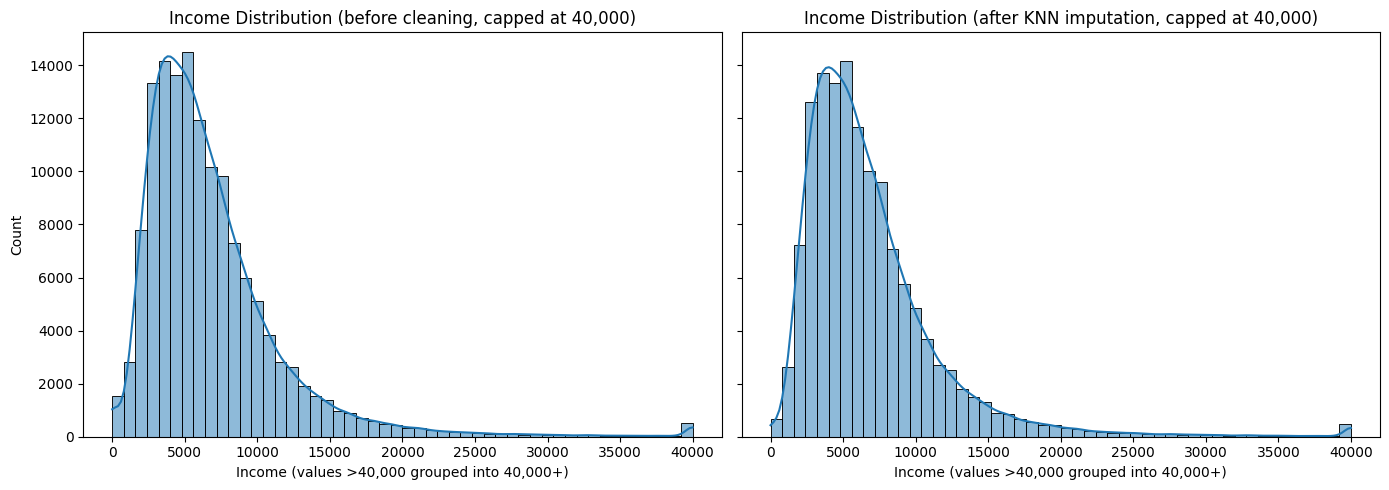

In [ ]:
# Compare Income Distribution Before vs After KNN Imputation

# Before imputation (from df_raw)
df_before = pd.to_numeric(df_raw.get("income"), errors="coerce")

# After KNN imputation (from df_final)
df_after = pd.to_numeric(df_final.get("income"), errors="coerce")

# Cap values for better visibility
df_before_capped = df_before.clip(upper=40000)
df_after_capped  = df_after.clip(upper=40000)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(df_before_capped, kde=True, bins=50, ax=axes[0])
axes[0].set_title("Income Distribution (before cleaning, capped at 40,000)")
axes[0].set_xlabel("Income (values >40,000 grouped into 40,000+)")

sns.histplot(df_after_capped, kde=True, bins=50, ax=axes[1])
axes[1].set_title("Income Distribution (after KNN imputation, capped at 40,000)")
axes[1].set_xlabel("Income (values >40,000 grouped into 40,000+)")

plt.tight_layout()
plt.show()


Now we want to see whether the dataset has outliers in income and dtir1. If so, we will remove them to concentrate on the 95% non-outliers.

Tukey outliers (reference, not necessarily removed):
  income low: 0 | income high: 6223
  dtir1  low: 2093 | dtir1  high: 0

Applied caps (max 2670 per tail per variable):
  income low removed: 0 | income high removed: 2670
  dtir1  low removed: 2093 | dtir1  high removed: 0

Total rows removed (union): 4501 of N_plot=133507 (3.37%); of N_total=133507 ≈ 3.37%


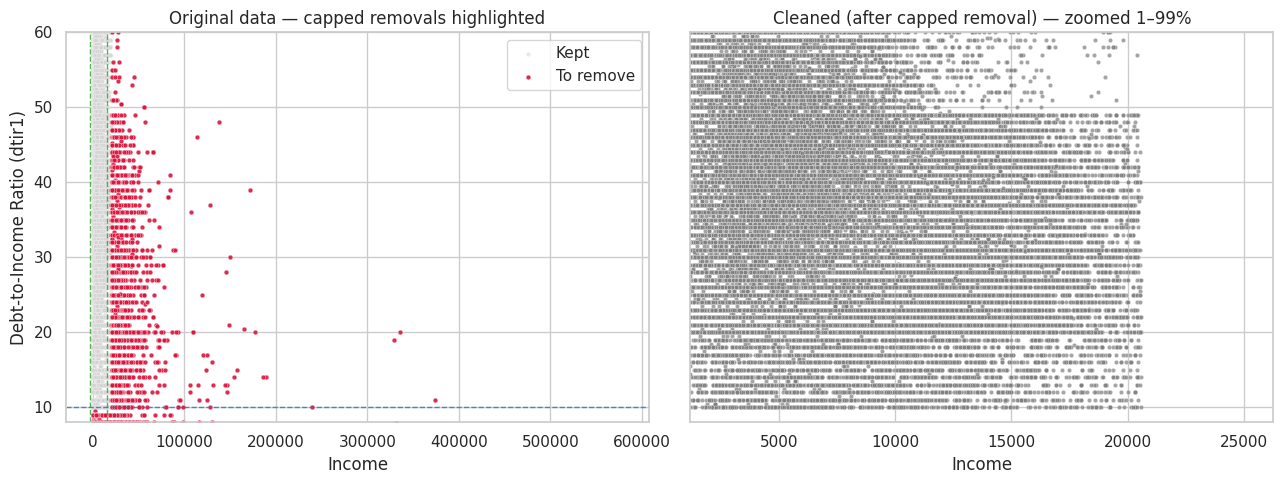


Applied to df_final: new shape (129006, 34) (was (133507, 34))


In [ ]:
# prepare data subset and sizes
# Outlier capping & removal with a max of 2% per tail (lower/upper) per variable,
# --- Prepare data (only needed columns; drop NaNs for plotting/statistics) ---
df_plot = df_final[["income", "dtir1"]].dropna().copy()
N = len(df_plot)
N_total = len(df_final)

# Tukey helper (1.5×IQR) to flag outliers and fences
# --- Tukey outlier detection (1.5 × IQR) for reference/fences ---
def tukey_flags(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    mask = (s < lo) | (s > hi)
    return mask, lo, hi, q1, q3, iqr

# compute Tukey flags/fences for both variables
mask_inc, inc_lo, inc_hi, inc_q1, inc_q3, inc_iqr = tukey_flags(df_plot["income"], k=1.5)
mask_dti, dti_lo, dti_hi, dti_q1, dti_q3, dti_iqr = tukey_flags(df_plot["dtir1"], k=1.5)

# build candidate index sets per side
# --- Build candidate indices (Tukey outliers per side) ---
inc_low_idx  = df_plot.index[df_plot["income"] < inc_lo]
inc_high_idx = df_plot.index[df_plot["income"] > inc_hi]
dti_low_idx  = df_plot.index[df_plot["dtir1"]  < dti_lo]
dti_high_idx = df_plot.index[df_plot["dtir1"]  > dti_hi]

# set per-tail cap (2% each side)
# --- Cap removal at max 2% per tail per variable (i.e., max 0.02 * N rows each side) ---
cap_per_tail = int(np.floor(0.02 * N))  # per side cap (lower or upper)

# keep at most k most extreme indices per side
def cap_side(series: pd.Series, idxs, take_lowest=True, k_cap=cap_per_tail):
    """From a set of candidate indices, keep at most k_cap of the most extreme ones."""
    idxs = list(idxs)
    if len(idxs) <= k_cap:
        return set(idxs)
    # Sort by value: ascending for lows, descending for highs
    sorted_idxs = sorted(idxs, key=lambda i: series.loc[i], reverse=not take_lowest)
    return set(sorted_idxs[:k_cap])

# apply caps per variable/side
inc_low_drop  = cap_side(df_plot["income"], inc_low_idx,  take_lowest=True)
inc_high_drop = cap_side(df_plot["income"], inc_high_idx, take_lowest=False)
dti_low_drop  = cap_side(df_plot["dtir1"],  dti_low_idx,  take_lowest=True)
dti_high_drop = cap_side(df_plot["dtir1"],  dti_high_idx, take_lowest=False)

# union of all rows to drop
# Union across variables/sides = rows to remove
drop_idx = set().union(inc_low_drop, inc_high_drop, dti_low_drop, dti_high_drop)

# quick stats on candidates and applied caps
# --- Print stats ---
print(f"Tukey outliers (reference, not necessarily removed):")
print(f"  income low: {len(inc_low_idx)} | income high: {len(inc_high_idx)}")
print(f"  dtir1  low: {len(dti_low_idx)} | dtir1  high: {len(dti_high_idx)}")
print(f"\nApplied caps (max {cap_per_tail} per tail per variable):")
print(f"  income low removed: {len(inc_low_drop)} | income high removed: {len(inc_high_drop)}")
print(f"  dtir1  low removed: {len(dti_low_drop)} | dtir1  high removed: {len(dti_high_drop)}")
print(f"\nTotal rows removed (union): {len(drop_idx)} of N_plot={N} ({len(drop_idx)/N:.2%}); "
      f"of N_total={N_total} ≈ {len(drop_idx)/N_total:.2%}")

# mask for highlighting removals in plot
# --- Create a mask to highlight what will be removed in the plot (relative to df_plot) ---
remove_mask_plot = df_plot.index.isin(drop_idx)

# zoom limits for cleaner right-hand plot
# --- Helpful view limits (quantile trim for the zoomed subplot) ---
x_lo, x_hi = np.quantile(df_plot["income"], [0.01, 0.99])
y_lo, y_hi = np.quantile(df_plot["dtir1"],  [0.01, 0.99])

# side-by-side: left original + highlights, right cleaned + zoom
# --- Plot: left = original with removals highlighted; right = cleaned view after removal ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# LEFT: original with Tukey fences and drop highlights
ax = axes[0]
sns.scatterplot(
    data=df_plot.loc[~remove_mask_plot], x="income", y="dtir1",
    color="lightgray", s=10, alpha=0.5, label="Kept", ax=ax
)
sns.scatterplot(
    data=df_plot.loc[remove_mask_plot], x="income", y="dtir1",
    color="crimson", s=12, alpha=0.9, label="To remove", ax=ax
)
# Draw Tukey fences (reference)
ax.axhline(dti_lo, ls="--", lw=1, color="tab:blue",  alpha=0.8)
ax.axhline(dti_hi, ls="--", lw=1, color="tab:blue",  alpha=0.8)
ax.axvline(inc_lo, ls="--", lw=1, color="tab:green", alpha=0.8)
ax.axvline(inc_hi, ls="--", lw=1, color="tab:green", alpha=0.8)
if (df_plot["income"] > 0).all():
    ax.set_xscale("log")
ax.set_title("Original data — capped removals highlighted")
ax.set_xlabel("Income")
ax.set_ylabel("Debt-to-Income Ratio (dtir1)")
ax.legend(loc="best", frameon=True)

# RIGHT: cleaned data (zoomed to 1–99%)
cleaned_plot = df_plot.loc[~remove_mask_plot]
ax = axes[1]
sns.scatterplot(
    data=cleaned_plot, x="income", y="dtir1",
    color="tab:gray", s=10, alpha=0.7, label=None, ax=ax
)
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)
ax.set_title("Cleaned (after capped removal) — zoomed 1–99%")
ax.set_xlabel("Income")
ax.set_ylabel("Debt-to-Income Ratio (dtir1)")

plt.tight_layout()
plt.show()

# apply the drop to df_final and report new shape
# --- Apply the removal to df_final itself (keep a copy first) ---
df_before_outlier_filter = df_final.copy()
df_final = df_final.drop(index=list(drop_idx), errors="ignore").reset_index(drop=True)
print(f"\nApplied to df_final: new shape {df_final.shape} (was {df_before_outlier_filter.shape})")

**Interpretation — Capped Outlier Removal (max 2% per tail per variable)**

- We identify outliers using **Tukey’s 1.5×IQR** rule to set *reference fences* for `income` and `dtir1`.  
- To avoid over-pruning, we **cap removals at 2% per tail** (lower and upper) **for each variable** and keep only the **most extreme** cases up to that cap.  
- The **left plot** shows the original data: points **in red** are those scheduled for removal; dashed lines indicate Tukey fences (reference).  
- The **right plot** shows the **cleaned dataset** (after removal), zoomed to the 1–99% range to reveal the core structure.  
- Result: We reduce extreme tails while preserving the bulk distribution, improving stability for downstream clustering/regression.


**Summary for the cleaning of the numerical attributes:**

- **Removed rows** with more than 5 missing values.  
- **Applied KNN Imputation (k=2)** on remaining missing numeric values.  
- KNN leverages **similar observations** instead of inserting a single fixed number,  
  which preserves the distribution and avoids distortion (e.g., artificial spikes at the median).  
- **Procedure:** For each missing value, KNN finds the *k most similar cases* (based on Euclidean distance) and imputes the missing entry with a weighted average of their values.  
- **Why it suits best:** This approach keeps the natural variability of the data, avoids systematic bias, and is especially useful for skewed variables like `income`. We can see in the plot above, that the distribution after the knn imputation has not changed significantly and hence won't bias further investigation.
- We also removed 3.37% of the outliers (including both sides) for our two variables
- Result: Clean numeric dataset with minimal loss of information and **realistic distributions**.  
- Next step: Handle missingness and cleaning for **categorical variables**.  


In [ ]:
# handle missing categorical values by dropping affected rows

# identify text-like columns
cat_cols = df_final.select_dtypes(include=["object", "string", "category"]).columns.tolist()

# standardize common "missing" tokens to NA and re-trim
if len(cat_cols) > 0:
    missing_tokens = ["", " ", "na", "n/a", "none", "null", "-", "--"]
    df_final[cat_cols] = (
        df_final[cat_cols]
        .apply(lambda s: s.astype("string"))
        .replace(missing_tokens, pd.NA)
        .apply(lambda s: s.str.strip())
    )

# drop rows with NA in any categorical column
print("Rows before dropping categorical missing values:", df_final.shape[0])
if len(cat_cols) > 0:
    df_final = df_final.dropna(subset=cat_cols)
print("Rows after dropping categorical missing values:", df_final.shape[0])

# reset index and show info
df_final = df_final.reset_index(drop=True)
df_final.info()

# remaining missingness summary
_ = get_missing_summary(df_final)


Rows before dropping categorical missing values: 129006
Rows after dropping categorical missing values: 125009
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125009 entries, 0 to 125008
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         125009 non-null  int64  
 1   year                       125009 non-null  int64  
 2   loan_limit                 125009 non-null  string 
 3   gender                     125009 non-null  string 
 4   approv_in_adv              125009 non-null  string 
 5   loan_type                  125009 non-null  string 
 6   loan_purpose               125009 non-null  string 
 7   credit_worthiness          125009 non-null  string 
 8   open_credit                125009 non-null  string 
 9   business_or_commercial     125009 non-null  string 
 10  loan_amount                125009 non-null  int64  
 11  rate_of_interest           12500

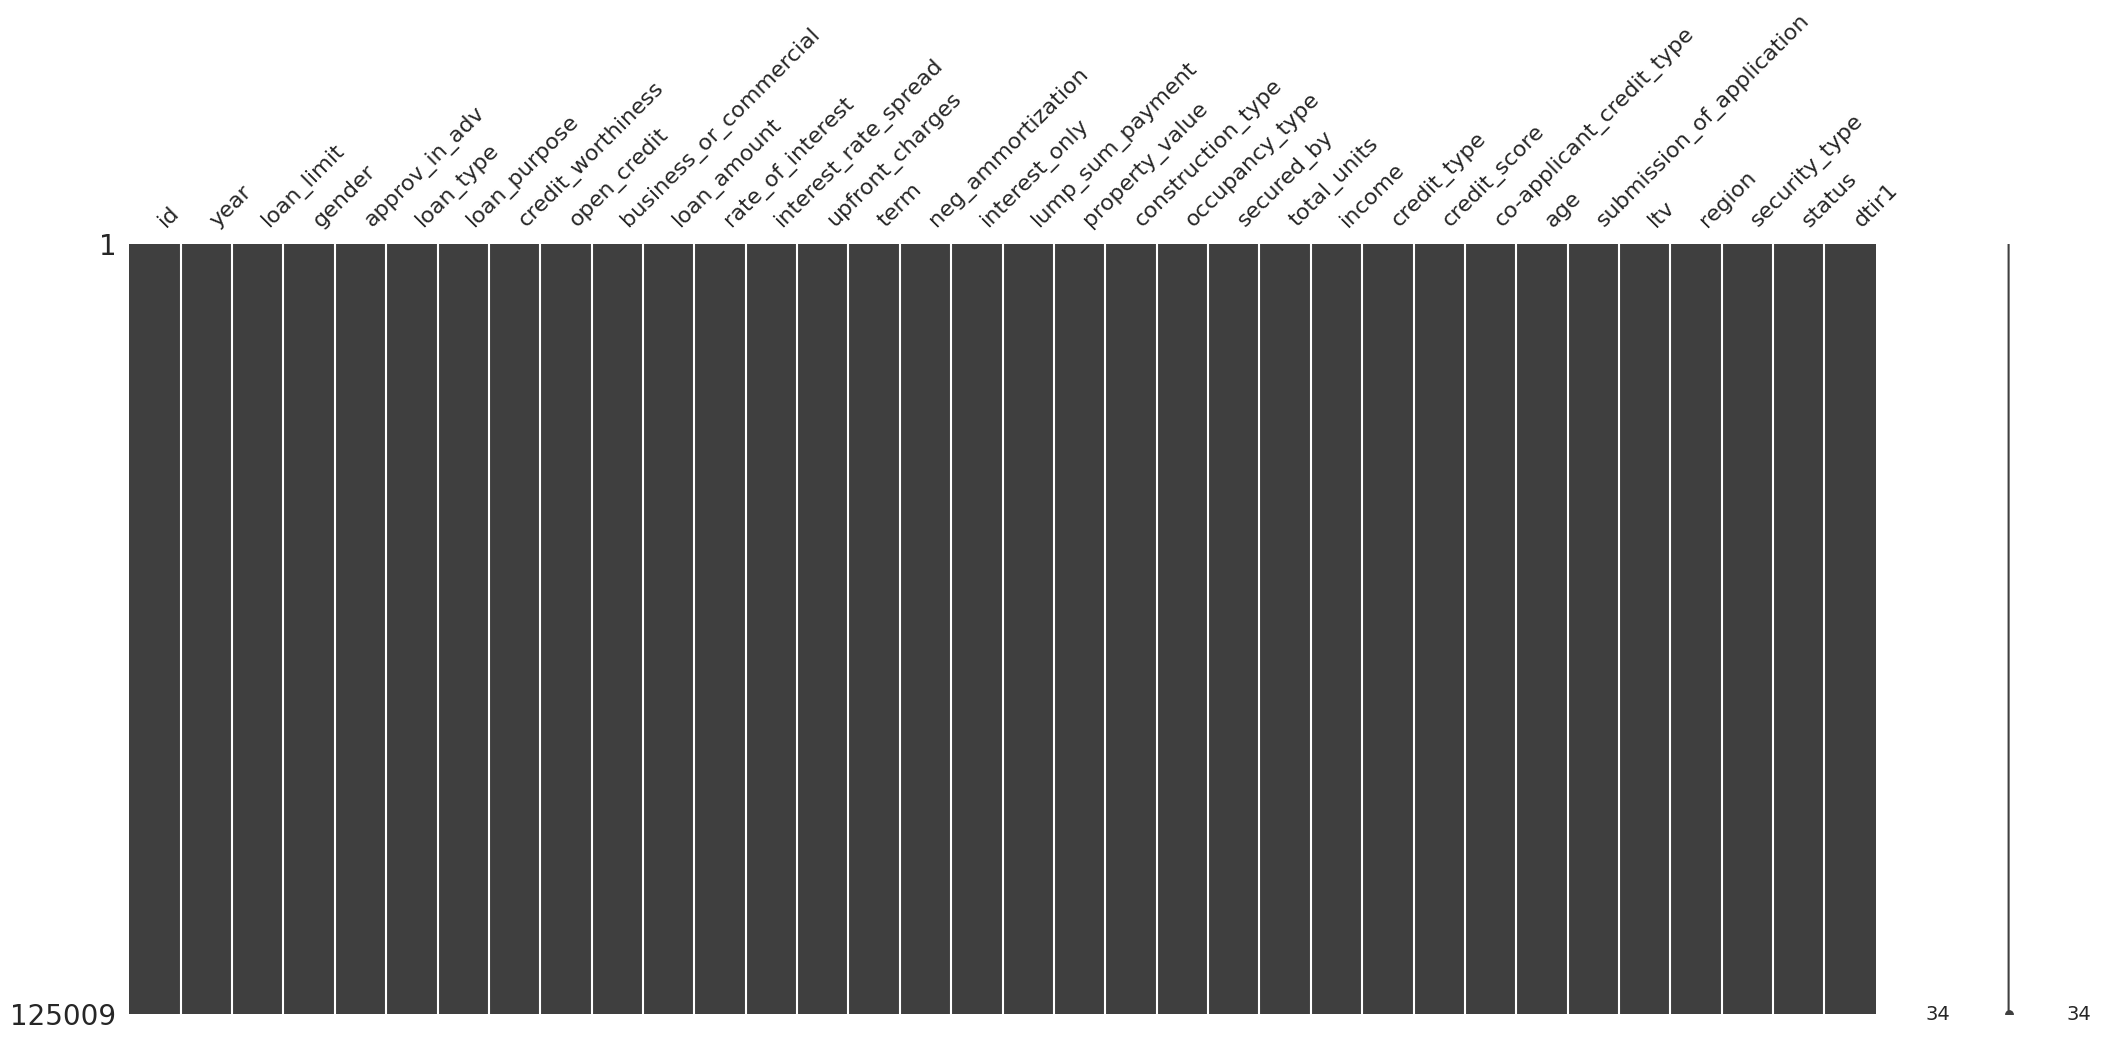

<Figure size 900x500 with 0 Axes>

In [ ]:
msno.matrix(df_final)
plt.figure(figsize=(9,5))
plt.show()

**Final Summary of the Cleaning Procedure**

- **Initial missingness:**  
  - High in `Upfront_charges` (27%), `Interest_rate_spread` (25%), `rate_of_interest` (25%).  
  - Medium in `dtir1` (16%), `property_value` & `LTV` (10%), `income` (6%).  
  - Several categorical features (e.g., `loan_limit`, `approv_in_adv`, `loan_purpose`) had small gaps (<3%).  

- **Numeric attributes:**  
  - Rows with more than 5 missing values were removed.  
  - Remaining missing numeric values in **`income` and `dtir1`** were imputed using **KNN (k=2)**.  
  - This preserved the natural distribution better than median imputation and avoided artificial spikes.  

- **Categorical attributes:**  
  - Rows containing missing categorical values were dropped. We decided against modul imputation, since the dataset is still large enough and the imputation increase the assumptions and hence the chance of false interpretations later.  
  - This reduced the dataset but avoided introducing artificial categories.  

- **Final dataset:**  
  - Reduced from **148,670 rows → 125,009 rows**.  
  - **No missing values remain** in either numeric or categorical variables.  


**Now we calculate the Monthly Debt**

Now, at the very last step of this section, we extract the debt as a seperate variable from the `dtir1` variable and add it to our df_final as `debt`. We can do that since we know the `income`.

In [ ]:
df_final["debt"] = (df_final["dtir1"] / 100) * df_final["income"]
print(df_final[["income", "dtir1", "debt"]].head(5))

    income  dtir1    debt
0   1740.0   45.0   783.0
1   9480.0   46.0  4360.8
2  11880.0   42.0  4989.6
3  10440.0   39.0  4071.6
4  10080.0   40.0  4032.0




---



## 3.2 Data Overview  

In the next steps, we will conduct a structured **overview of the cleaned dataset** to better understand its key characteristics. This is a critical step before any hypothesis testing, as it helps us gain insights into the structure and relationships within the data.

Specifically, we will:  
- **Summarize distributions** of key numeric variables such as `income` and `debt` using descriptive statistics (mean, standard deviation, median, IQR, min/max).  
- **Visualize important patterns** through plots of `income` and `debt`.  
- **Explore initial associations** using a scatter plot (`income` vs. `debt`) and a correlation heatmap of all numeric variables.  

These steps will help us understand the **shape, skewness, and inter-variable relationships** before proceeding to more formal modeling and hypothesis testing.


Rows, columns: (125009, 35)
Numeric columns: 14 | Categorical columns: 21
Numerical variables: ['id', 'year', 'loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1', 'debt']
Categorical variables: ['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'region', 'security_type']

Summary of key variables (income, debt):


,mean,sd,median,IQR,min,max
income,6418.51,3600.20,5700.0,4440.0,0.0,20580.0
debt,2382.81,1321.47,2138.4,1622.4,0.0,11682.0


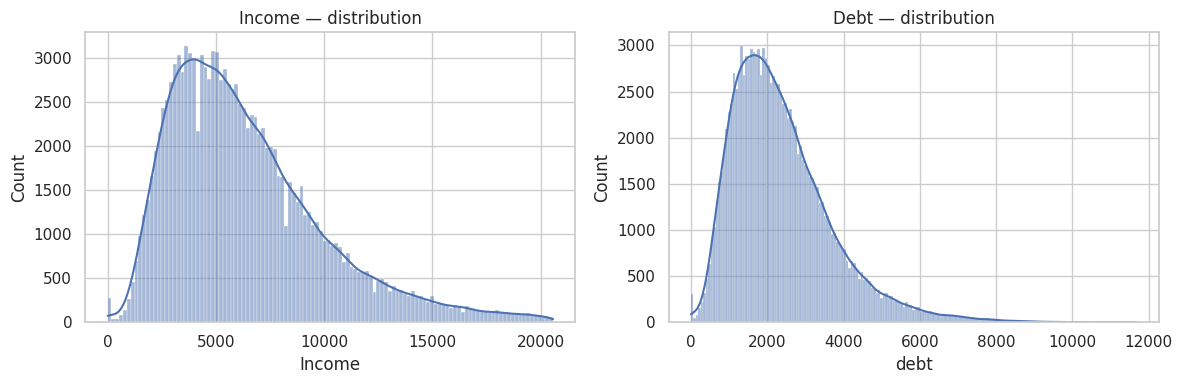

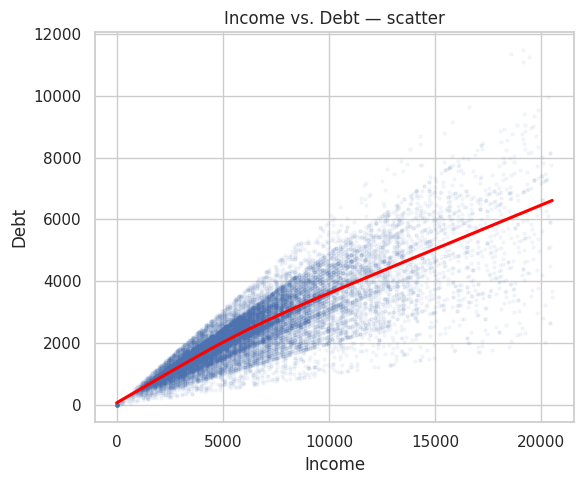

In [ ]:
# identify numeric vs categorical variables (handle pandas 'string' dtype)
num_vars = df_final.select_dtypes(include=["number"]).columns.tolist()
cat_vars = df_final.select_dtypes(include=["object", "category", "bool", "string"]).columns.tolist()

print(f"Rows, columns: {df_final.shape}")
print(f"Numeric columns: {len(num_vars)} | Categorical columns: {len(cat_vars)}")
print("Numerical variables:", num_vars[:])
print("Categorical variables:", cat_vars[:])

# compact summary for all numeric variables
summary_stats = df_final[num_vars].describe().T
summary_stats["median"] = df_final[num_vars].median()
summary_stats["IQR"] = df_final[num_vars].quantile(0.75) - df_final[num_vars].quantile(0.25)
summary_stats = summary_stats[["count", "mean", "std", "median", "IQR", "min", "max"]].round(2)
summary_stats

# key variables of interest: income & debt (fallback: compute debt if missing using dtir1 as percent)
if "debt" not in df_final.columns:
    if "dtir1" in df_final.columns and "income" in df_final.columns:
        df_final = df_final.copy()
        df_final["debt"] = pd.to_numeric(df_final["dtir1"], errors="coerce")/100.0 * pd.to_numeric(df_final["income"], errors="coerce")
    else:
        raise ValueError("Neither 'debt' nor the components to derive it ('income' and 'dtir1') are available.")

vars_of_interest = ["income", "debt"]
missing_vois = [v for v in vars_of_interest if v not in df_final.columns]
if missing_vois:
    print(f"Warning: Not found in DataFrame: {missing_vois}. Please adjust the column names.")
else:
    key = df_final[vars_of_interest].copy()

    # table with mean, SD, median, IQR, min, max
    key_summary = pd.DataFrame({
        "mean": key.mean(numeric_only=True),
        "sd": key.std(numeric_only=True),
        "median": key.median(numeric_only=True),
        "IQR": key.quantile(0.75, numeric_only=True) - key.quantile(0.25, numeric_only=True),
        "min": key.min(numeric_only=True),
        "max": key.max(numeric_only=True)
    }).round(2)
    print("\nSummary of key variables (income, debt):")
    display(key_summary)

    # cap income for plotting
    key["income_capped"] = pd.to_numeric(key["income"], errors="coerce").clip(upper=40000)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=key, x="income_capped", kde=True, ax=axes[0])
    axes[0].set_title("Income — distribution")
    axes[0].set_xlabel("Income")

    sns.histplot(data=key, x="debt", kde=True, ax=axes[1])
    axes[1].set_title("Debt — distribution")
    axes[1].set_xlabel("debt")
    plt.tight_layout()
    plt.show()

    # scatter with smoothed LOWESS trend (sampled if too large)
    plot_sample = key.sample(n=20000, random_state=42) if len(key) > 20000 else key
    plt.figure(figsize=(6, 5))
    sns.regplot(
        data=plot_sample,
        x="income_capped",
        y="debt",
        scatter_kws={"alpha": 0.05, "s": 5},
        lowess=True,
        line_kws={"color": "red"}
    )
    plt.title("Income vs. Debt — scatter")
    plt.xlabel("Income")
    plt.ylabel("Debt")
    plt.tight_layout()
    plt.show()


**Key takeaways (short):**

- **Dataset:** 125,008 rows, 35 columns (14 numeric, 21 categorical).  
- **Income & Debt:** both right-skewed (median income ≈ 5,700; median debt ≈ 2,138).  
- **Scatter (income vs. debt):** strong **positive** slope with distinct **linear bands** (rays) from the origin.  
  - These bands likely reflect **policy thresholds/rounding or product tiers** that scale borrowing roughly proportionally to income, yielding parallel lines with increasing slopes.  
  - The cloud widens with income → **heteroskedasticity** is likely; HC3or log transformation might be appropriate.

**Next:** we formally test significance and functional form (heteroskedasticity checks, possible transformations, BLUE etc.).


**Descriptive Relationships**  


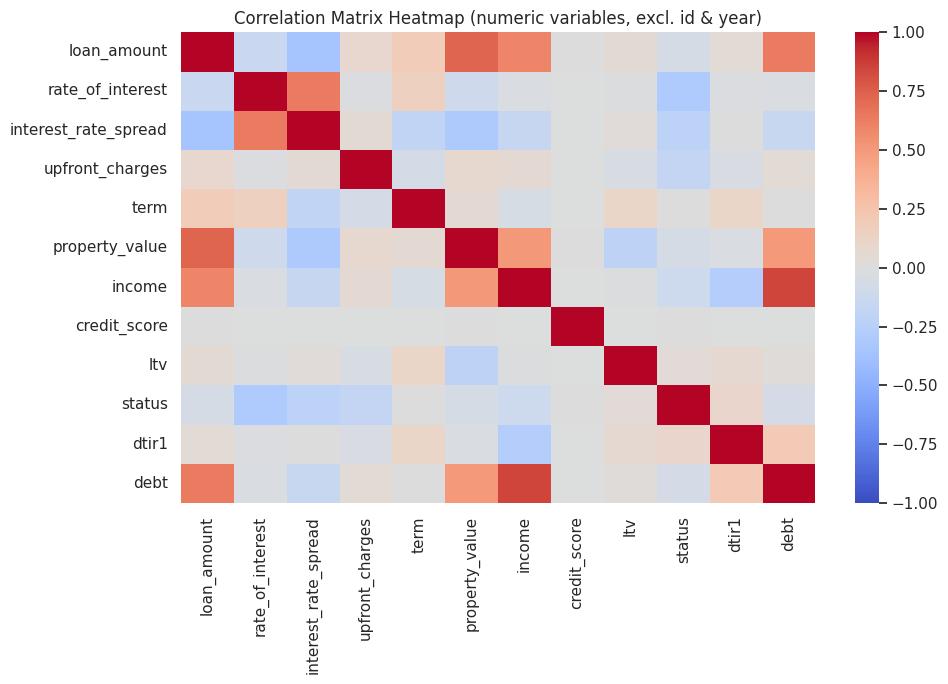

In [ ]:
# Correlation matrix heatmap for all numeric variables, excluding id/year (case-insensitive)

# Collect numeric columns
num_vars = df_final.select_dtypes(include=["number"]).columns.tolist()

# Exclude id/year with case-insensitive check
exclude = {"id", "year"}
num_vars = [c for c in num_vars if c.lower() not in exclude]

# Guard: need at least 2 numeric variables to compute a correlation matrix
if len(num_vars) < 2:
    raise ValueError("Not enough numeric variables (excluding id/year) to compute a correlation matrix.")

# Correlation matrix (Pearson by default)
corr_matrix = df_final[num_vars].corr(method="pearson")

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (numeric variables, excl. id & year)")
plt.tight_layout()
plt.show()


N used: 125,009
Pearson correlation (income, debt): r = 0.8443, p = 0.000e+00
Spearman correlation (income, debt): rho = 0.8667, p = 0.000e+00


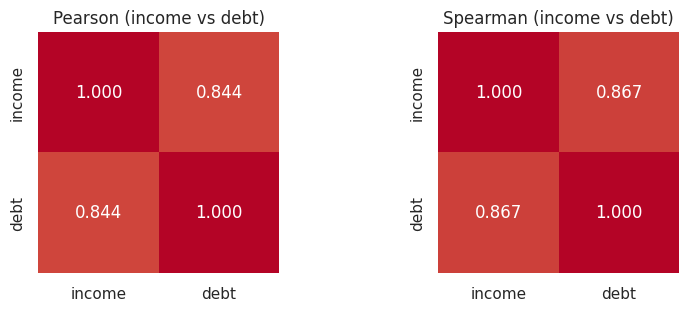

In [ ]:
# prepare numeric pair (no sampling); guard required cols
# --- Prepare numeric data for income vs debt (no sampling) ---
cols = ["income", "debt"]
missing = [c for c in cols if c not in df_final.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

pair = df_final[cols].apply(pd.to_numeric, errors="coerce").dropna()

x = pair["income"].values
y = pair["debt"].values

# compute Pearson & Spearman correlations (with p-values)
# --- Compute coefficients & p-values ---
pearson_r, pearson_p = pearsonr(x, y)
spearman_rho, spearman_p = spearmanr(x, y)

print(f"N used: {len(pair):,}")
print(f"Pearson correlation (income, debt): r = {pearson_r:.4f}, p = {pearson_p:.3e}")
print(f"Spearman correlation (income, debt): rho = {spearman_rho:.4f}, p = {spearman_p:.3e}")

# small 2×2 correlation matrices for plotting
# --- Build 2x2 correlation matrices for visualization ---
corr_pearson = pair.corr(method="pearson")
corr_spearman = pair.corr(method="spearman")

# side-by-side heatmaps
# --- Plot side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

sns.heatmap(
    corr_pearson, annot=True, fmt=".3f",
    cmap="coolwarm", center=0, vmin=-1, vmax=1,
    cbar=False, square=True, ax=axes[0]
)
axes[0].set_title("Pearson (income vs debt)")

sns.heatmap(
    corr_spearman, annot=True, fmt=".3f",
    cmap="coolwarm", center=0, vmin=-1, vmax=1,
    cbar=False, square=True, ax=axes[1]
)
axes[1].set_title("Spearman (income vs debt)")

plt.show()

**Interpretation & Key Insights**

The 2×2 heatmaps summarize the association between `income` and `debt` using **Pearson** (linear) and **Spearman** (rank/monotonic) correlations. Both metrics show a **strong positive** relationship.

- **Pearson:** r = **0.844**, p < 0.001 — strong **linear** correlation.  
- **Spearman:** ρ = **0.8667**, p < 0.001 — strong **monotonic** association.

**Takeaway:** Higher income is associated with **higher absolute debt**.

**Next Chapter – Linear Regression:**  
Correlations confirm direction and strength, but a regression model of **`debt`** on the selected predictors will (i) **quantify effect sizes**, (ii) enable **prediction**, and (iii) allow **assumption checks** (e.g., heteroskedasticity).



---



---



# 4 Method 1 — Simple Linear Regression (`debt ~ income`)

### 4.1 Why this method?  

We apply a **linear regression framework** because it is simple, interpretable, and fits our research question of identifying which factors explain variations in `debt`.  

As a first step, we estimate a **baseline model** (`debt ~ income`), which captures the most intuitive relationship: household income as the main determinant of debt.  

In a second step, we also study an **expanded model**, where additional variables related to loan and borrower characteristics are included. This allows us to test whether the explanatory power of the model improves when controlling for more factors.  




#### 4.1.1 Feature Selection with Cross-Validation (CV)  

To improve the explanatory power of our regression model, we applied a systematic feature selection strategy using Cross-Validation (CV). With forward selection in combination with regularization techniques (ElasticNet), we tested both numerical and categorical predictors. Variables were retained only if they contributed a meaningful increase in out-of-sample R², ensuring that the final model remained parsimonious while still capturing the most important drivers of `debt`.  

The CV process identified the following predictors as most relevant:  
- **Numerical:** `income`, `loan_amount`, `rate_of_interest`, `interest_rate_spread`, `term`, `status`  
- **Categorical:** `occupancy_type`, `loan_type`, `loan_purpose`  

An OLS regression model was then estimated with these variables. The final model achieved an **R² of approximately 76%**, substantially higher than the baseline numeric-only specification. This indicates that both loan characteristics (e.g., interest rates, term, loan type) and borrower context (e.g., occupancy type, loan purpose) play an important role in explaining variations in `debt`.  

A detailed explanation of the CV-based selection procedure would go beyond the scope of this project. Therefore, the set of variables identified above should be considered as given for the following interpretation.  



In [ ]:
# Keep raw variable names
num_vars = [
    "income", "loan_amount", "rate_of_interest",
    "interest_rate_spread", "term", "status"
]

cat_vars = [
    "occupancy_type", "loan_type", "loan_purpose"
]

# Build formula: numeric vars + categorical vars wrapped in C()
final_formula = "debt ~ " + " + ".join(
    num_vars + [f"C({c})" for c in cat_vars]
)

# --- Prepare a clean modeling frame ---
vars_used = num_vars + cat_vars + ["debt"]
df_model = df_final[vars_used].copy()

# Cast categoricals to 'category' dtype for patsy/statsmodels compatibility
for c in cat_vars:
    df_model[c] = df_model[c].astype("category")

# Ensure numeric columns are properly numeric
for c in num_vars + ["debt"]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# Drop rows with missing values in any modeling column
df_model = df_model.dropna()

### 4.2 Model Specification  





#### 4.2.1 Baseline model  
We first estimate a baseline model that includes only household income as an explanatory variable:  

- **Baseline model:** `debt ~ income`  

This model tests whether income alone can explain variations in household debt.  


In [ ]:
# Baseline model: debt explained by income
model_base = smf.ols('debt ~ income', data=df_final).fit()

# Store fitted values and residuals for diagnostics
df_final["fitted_base"] = model_base.fittedvalues
df_final["residuals_base"] = model_base.resid

# Show regression results
print(model_base.summary())




                            OLS Regression Results                            
Dep. Variable:                   debt   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 3.104e+05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:39:54   Log-Likelihood:            -9.9775e+05
No. Observations:              125009   AIC:                         1.996e+06
Df Residuals:                  125007   BIC:                         1.996e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    393.6031      4.094     96.151      0.0

**Base Model Interpretation**

$$
debt_i = 393.6 \;+\; 0.3099 \cdot income_i \;+\; \varepsilon_i
$$

The model shows a **significant and positive relationship** between income and debt:  

- **Income coefficient (0.3099):** each additional unit of income increases debt, on average, by 0.31 units.  
- **H<sub>0</sub> is rejected:** p-value ≈ 0.000 (p-value < α) and **IC<sub>0.95</sub>** [0.309; 0.311] (the interval does not include 0). This indicates that the effect of income is highly significant.  
- **$R^2 = 0.713$:** 71% of the variation in debt is explained by income. This is considered a high value for such a simple model.  

**Conclusion**  
Income is clearly one of the main determinants of debt. However, 29% of the variation remains unexplained, which motivates the analysis of the expanded model.  




#### 4.2.2 Expanded model  

In the second step, we estimate an **expanded model** that includes not only income but also additional numerical and categorical loan-related variables.  

- **Expanded model:**  
  `debt ~ income + loan_amount + rate_of_interest + interest_rate_spread + term + status + C(occupancy_type) + C(loan_type) + C(loan_purpose)`  

The goal of this specification is to test whether household debt is influenced not only by income, but also by loan characteristics and categorical borrower features
By adding these variables, we can assess whether the explanatory power (R²) improves compared to the baseline model, and whether income remains a significant determinant once more factors are accounted for.  



In [ ]:
# Expanded model - standard OLS
model_expanded = smf.ols(formula=final_formula, data=df_model).fit()

# Store fitted values and residuals for diagnostics
df_model["fitted_expanded"] = model_expanded.fittedvalues
df_model["residuals_expanded"] = model_expanded.resid

# Show regression results
print(model_expanded.summary())


                            OLS Regression Results                            
Dep. Variable:                   debt   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 2.969e+04
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:39:55   Log-Likelihood:            -9.8776e+05
No. Observations:              125009   AIC:                         1.976e+06
Df Residuals:                  124995   BIC:                         1.976e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Expanded Model Interpretation**

- The expanded model explains household debt better:  
  $R^2$ increases from ≈71% (baseline) to ≈76%.  

- **Income coefficient (0.2582, p < 0.001):** remains positive and highly significant, confirming its importance even after the inclusion of other variables.  

- **Additional variables:** several loan characteristics and categorical factors also appear as significant determinants of debt.  






#### 4.2.3 Comparison of Results


Comparing the two models, some key conclusions emerge:  

- **Explanatory power:** the baseline model explains about 71% of the variation in `debt`, while the expanded model increases this to roughly 76%. Although the gain is modest, it shows that loan characteristics and categorical borrower factors add value to the analysis.  

- **Income:** in both models, income remains positive and highly significant. This confirms that income is the main determinant of household debt, even after controlling for additional variables.  

- **Additional variables:** in the expanded model, several loan-specific factors (loan amount, interest rate, term, status) and categorical variables (loan type, occupancy type, loan purpose) are statistically significant. This indicates that the debt level is not solely a function of income, but is also shaped by the conditions of the loan and the borrower’s context.  

**Conclusion:**  
The baseline model highlights the central role of income, while the expanded model refines this picture by incorporating loan and borrower characteristics. Income remains the strongest driver of debt, but the expanded specification confirms that household indebtedness is a multifactor phenomenon.  


#### 4.2.4 Log Transformation

In this section, we applied a logarithmic transformation to the variables in both the base and expanded models.
**We decided to do this mainly out of curiosity**, to see how the results would change after applying the transformation. The log transformation is often used to reduce skewness, limit the effect of outliers, and linearize relationships between variables.

**This step is only exploratory, and we will not focus on the log-transformed models in the following analysis.**

In [ ]:
# Log-transformed model- Baseline Model
model_base_log = smf.ols('np.log1p(debt) ~ np.log1p(income)', data=df_final).fit()

# Store fitted values and residuals
df_final["fitted_base_log"] = model_base_log.fittedvalues
df_final["residuals_base_log"] = model_base_log.resid

# Show regression results
print(model_base_log.summary())

# Compare R² with the base model
print("\nR² comparison:")
print(f"Base model: {model_base.rsquared:.4f}")
print(f"Log-transformed model: {model_base_log.rsquared:.4f}")



                            OLS Regression Results                            
Dep. Variable:         np.log1p(debt)   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 5.895e+05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:28:57   Log-Likelihood:                -19086.
No. Observations:              125009   AIC:                         3.818e+04
Df Residuals:                  125007   BIC:                         3.820e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0609      0.010  

In [ ]:
# Log Transformation – Expanded Model
# Step 1: Remove rows with negative values in numeric variables

# Keep only rows where all numeric variables (and debt) are >= 0
df_model = df_model[(df_model[num_vars + ['debt']] >= 0).all(axis=1)].copy()

# Step 2: Create log-transformed versions of numeric variables
for c in num_vars:
    df_model[f'log_{c}'] = np.log1p(df_model[c])

# Step 3: Build new formula with log-transformed numeric vars and categorical vars
final_formula_log = "np.log1p(debt) ~ " + " + ".join(
    [f'np.log1p({c})' for c in num_vars if c != 'debt'] + [f'C({c})' for c in cat_vars]
)

# Step 4: Fit the log-transformed expanded model
model_expanded_log = smf.ols(final_formula_log, data=df_model).fit()

# Step 5: Store fitted values and residuals
df_model["fitted_expanded_log"] = model_expanded_log.fittedvalues
df_model["residuals_expanded_log"] = model_expanded_log.resid

# Step 6: Display regression summary and compare R² values
print(model_expanded_log.summary())

print("\nR² comparison:")
print(f"Expanded model:     {model_expanded.rsquared:.4f}")
print(f"Log-expanded model: {model_expanded_log.rsquared:.4f}")



                            OLS Regression Results                            
Dep. Variable:         np.log1p(debt)   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                 3.772e+04
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:36:38   Log-Likelihood:                -5335.9
No. Observations:               95648   AIC:                         1.070e+04
Df Residuals:                   95634   BIC:                         1.083e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

**Note: We used np.log1p() instead of np.log() because it safely handles zero values by computing log(1 + x), allowing us to keep all observations while achieving the same transformation effect.**

**Conclusions on the Log transformation**

The log transformation was applied to both models mainly out of curiosity, to observe its effect on model fit and interpretation.
After removing negative values and applying np.log1p() to the numeric variables, the results showed that the **R² remained similar or slightly higher**, indicating that the explanatory power of the model did not change significantly.

The transformation **slightly improved residual behaviour** and allowed the coefficients to be interpreted in percentage terms, but overall, the original linear model already performed well.
Thus, the log transformation served as a useful robustness check, but the following analysis continues to focus on the non-transformed models.

###4.3 Model Assumption

Following the Gauss-Markov framework discussed in class, we now test whether the assumptions required for OLS to be considered BLUE hold in our models.  

We will check the main assumptions step by step:  
1. Linearity  
2. Homoscedasticity  
3. Normality of residuals  
4. Multicollinearity  
5. Independence of errors  

These tests will be applied to both the baseline and the expanded models.  


#### 4.3.1 Linearity

We will start by checking whether the relationship between the predictors and `debt` is linear.  
We analyze this visually by plotting the fitted values against the residuals for both the baseline and the expanded models.  

If the linearity assumption holds, no systematic pattern should be observed in the plots.  



##### **A. Baseline Model**

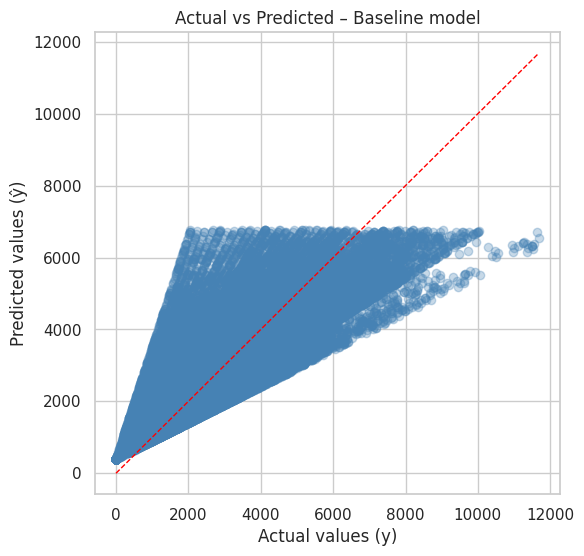

In [ ]:
# Actual (x-axis) vs Predicted (y-axis) – Baseline model
plt.figure(figsize=(6, 6))

# Scatter plot: actual on X, predicted on Y
plt.scatter(df_final['debt'], model_base.fittedvalues, alpha=0.3, color="steelblue")

# 45-degree line (perfect predictions)
plt.plot(
    [df_final['debt'].min(), df_final['debt'].max()],
    [df_final['debt'].min(), df_final['debt'].max()],
    color="red", linestyle="--", linewidth=1
)

plt.xlabel("Actual values (y)")
plt.ylabel("Predicted values (ŷ)")
plt.title("Actual vs Predicted – Baseline model")
plt.show()



**Baseline Model Interpretation - Linearity**

The scatter plot confirms a **positive linear relationship** between actual and predicted values, supporting the validity of the linearity assumption.  

Most points follow the 45° reference line, showing that the model captures well the link between `income` and `debt`.  
However, for higher levels of debt, predictions tend to fall **below the diagonal**, meaning the model **underestimates debt at higher values**.  

Overall, the relationship remains linear, and no systematic non-linear patterns are detected, although the fit is less accurate for extreme observations.  



##### **B. Expanded Model**

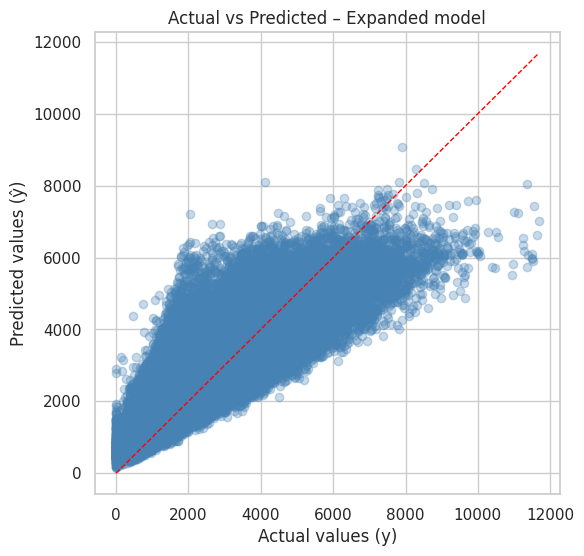

In [ ]:
# Actual vs Predicted plot – Expanded model
plt.figure(figsize=(6, 6))

# Scatter plot: actual on X, predicted on Y
plt.scatter(df_model['debt'], model_expanded.fittedvalues, alpha=0.3, color="steelblue")

# 45-degree line (perfect predictions)
plt.plot(
    [df_model['debt'].min(), df_model['debt'].max()],
    [df_model['debt'].min(), df_model['debt'].max()],
    color="red", linestyle="--", linewidth=1
)

plt.xlabel("Actual values (y)")
plt.ylabel("Predicted values (ŷ)")
plt.title("Actual vs Predicted – Expanded model")
plt.show()



**Expanded Model Interpretation-  Linearity**  

The graph shows a pattern similar to the baseline model.  
The points follow the linear trend around the 45° line, with no evidence of a violation of the linearity assumption.  





##### **C. Comparison of Results**  

The graphical analysis shows that the **linearity** assumption is satisfied by both models.  

- In the **baseline model**, the relationship between `income` and `debt` is well captured by the linear regression, with the points aligned along the 45° line.  

- The **expanded model** shows a similar behavior, with points following the same trend and no evidence of non-linear patterns.  

Therefore, we can conclude that **regarding this assumption, the models do not present relevant differences**, and the linearity assumption is reasonably satisfied in both cases.  






#### 4.3.2 Homoscedasticity

For this assumption we test whether the errors variance maintains a contant value for the fitted values
$$
\text{Var}(\varepsilon_i) = \sigma^2
$$  

Otherwise, we have **heterocedasticity**
$$
\text{Var}(\varepsilon_i) \neq \sigma^2
$$  

In this case, OLS coefficients remain unbiased, but the standard errors become unreliable, and therefore confidence intervals and hypothesis tests.



##### **A. Baseline Model**

For our study, we used two methods:  

- **Fitted values vs. residuals graph:** the fitted values ($\hat{y}_i$) are the predictions made by the model, while the residuals ($\hat{\varepsilon}_i = y_i - \hat{y}_i$) represent the difference between the actual and predicted values.  

- **Breusch–Pagan test:** used to test the null hypothesis of constant variance ($H_0$).  




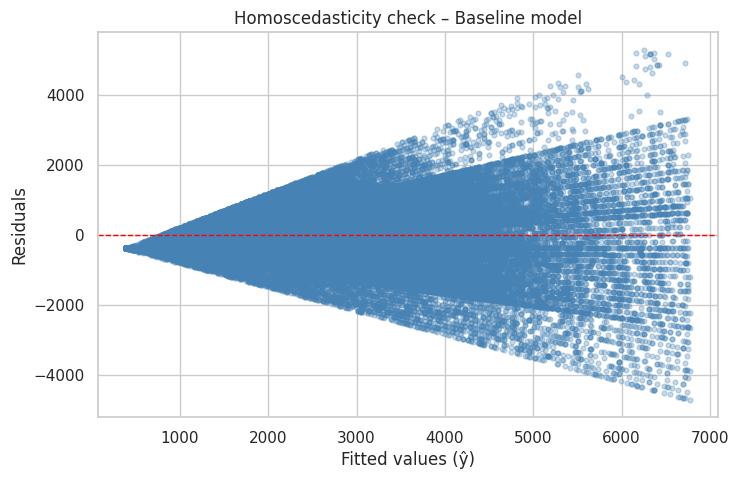

{'Lagrange multiplier statistic': np.float64(29569.331714609747), 'p-value': np.float64(0.0), 'F-statistic': np.float64(38729.94862676043), 'F p-value': np.float64(0.0)}


In [ ]:
# Compute fitted values and residuals for the baseline model
fitted_base = model_base.fittedvalues
residuals_base = model_base.resid

# Fitted vs Residuals plot
plt.figure(figsize=(8, 5))
plt.scatter(fitted_base, residuals_base, alpha=0.3, s=12, color="steelblue")
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("Residuals")
plt.title("Homoscedasticity check – Baseline model")
plt.show()

# Breusch–Pagan test for heteroscedasticity
# H0: residuals are homoscedastic (constant variance)
# H1: residuals are heteroscedastic
bp_test = het_breuschpagan(residuals_base, model_base.model.exog)

# Organize test output
labels = ["Lagrange multiplier statistic", "p-value", "F-statistic", "F p-value"]
print(dict(zip(labels, bp_test)))


**Baseline Model - Homoscedasticity**  

The *Fitted vs Residuals* plot shows a clear cone-shaped pattern, indicating that the variance of the residuals increases with the fitted values. The further the residuals are from zero, the larger the prediction error, showing that the model fits worse for higher levels of `debt`.  

The **Breusch-Pagan test** confirms this: with p-value ≈ 0.000, we reject $H_0$ and conclude that heteroscedasticity is present.  




##### **B. Expanded Model**


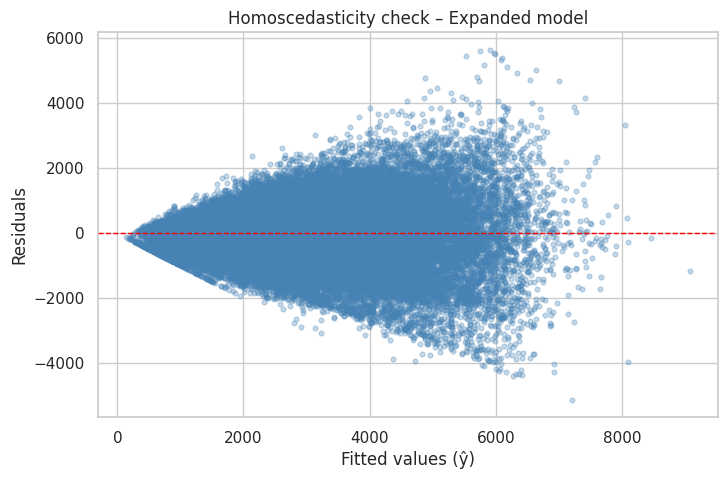

{'Lagrange multiplier statistic': np.float64(30647.375867527633), 'p-value': np.float64(0.0), 'F-statistic': np.float64(3122.82160968945), 'F p-value': np.float64(0.0)}


In [ ]:
# Compute fitted values and residuals for the expanded model
fitted_expanded = model_expanded.fittedvalues
residuals_expanded = model_expanded.resid

#  Residuals vs Fitted plot
plt.figure(figsize=(8, 5))
plt.scatter(fitted_expanded, residuals_expanded, alpha=0.3, s=12, color="steelblue")
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("Residuals")
plt.title("Homoscedasticity check – Expanded model")
plt.show()

# Beusch–Pagan test for heteroscedasticity
# H0: residuals are homoscedastic (constant variance)
# H1: residuals are heteroscedastic
bp_test_expanded = het_breuschpagan(residuals_expanded, model_expanded.model.exog)

# Organize and display test results
labels = ["Lagrange multiplier statistic", "p-value", "F-statistic", "F p-value"]
print(dict(zip(labels, bp_test_expanded)))



**Expanded Model - Homoscedasticity**
  

The expanded model shows the same cone-shaped pattern as the baseline.  
The Breusch-Pagan test (p-value ≈ 0.000) confirms that heteroscedasticity persists.  

➡ No relevant improvement compared to the baseline.  




##### **C. Comparison of Results**  

Both models reveal a cone-shaped pattern in the *Fitted vs Residuals* plots, showing that residual variance increases with the fitted values.  
The **Breusch-Pagan test** confirms this finding in both cases (p-value ≈ 0.000), leading to the rejection of $H_0$.  

Therefore, we conclude that **both models violate the homoscedasticity assumption**. Although the expanded model improves explanatory power, it does not address this issue. As a result, OLS coefficients remain unbiased, but standard errors and statistical inference are unreliable.  



##### **D. Heteroscedasticity Robust Standard Errors**  

Since both models present **heteroscedasticity**, the traditional standard errors are not reliable for statistical inference (confidence intervals and p-values).  
Therefore, we use **robust standard errors (HC3)**, which provide consistent results even under non-constant variance.  
The objective is to ensure that our conclusions about the significance of the variables are **statistically valid**.  







In [ ]:
# Robust standard errors – Baseline model
robust_base = smf.ols('debt ~ income', data=df_final).fit(cov_type="HC3")

# Robust standard errors – Expanded model
robust_expanded = smf.ols(final_formula, data=df_model).fit(cov_type="HC3")

print(robust_base.summary())
print("")
print(robust_expanded.summary())


                            OLS Regression Results                            
Dep. Variable:                   debt   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 1.020e+05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:39:58   Log-Likelihood:            -9.9775e+05
No. Observations:              125009   AIC:                         1.996e+06
Df Residuals:                  125007   BIC:                         1.996e+06
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    393.6031      5.071     77.623      0.0

**Models with HC3**  

To address the heteroscedasticity problem, we re-estimated both models using the HC3 method, ensuring reliable statistical inference.  

- In the **baseline model** (`debt ~ income`), `income` is highly significant and positive, explaining about **71% of the variation in `debt`**.  

- In the **expanded model**, `income` remains significant, although with less impact. Additional variables such as `loan_amount`, `rate_of_interest`, `status`, and categories like `loan_type` and `loan_purpose` also show statistical significance. The **explanatory power increases to 75.5%**.  



#### 4.3.3 Normality of Residuals  

The normality of residuals is an important assumption in linear regression, mainly for the purpose of **statistical inference**.  
Although the estimation of OLS coefficients does not depend on this condition, statistical tests assume that residuals follow approximately a normal distribution:  

$$
\varepsilon_i \sim N(0, \sigma^2)
$$  

By verifying the normality of residuals, we can ensure that statistical conclusions are reliable.  
In our study, we use a **Q-Q plot** as a graphical tool and the **Jarque-Bera test** as a formal test.  



##### **A. Baseline Model**

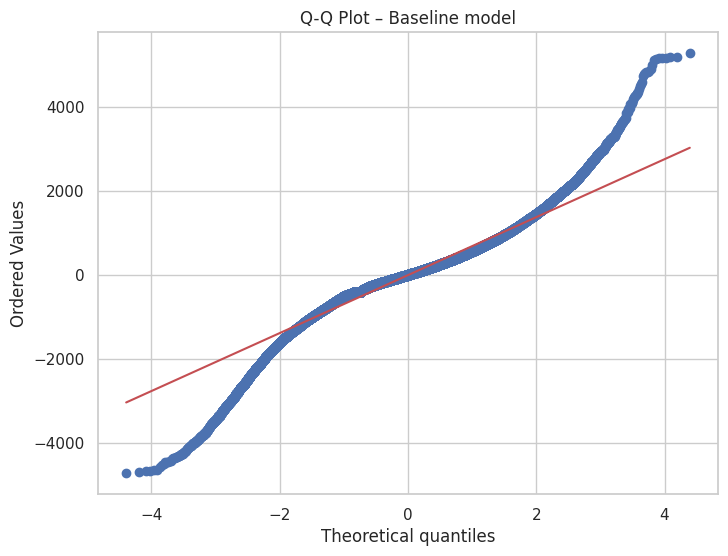

{'JB statistic': np.float64(87608.03923621112), 'p-value': np.float64(0.0), 'skew': np.float64(-0.33784947452189684), 'kurtosis': np.float64(7.045116000471643)}


In [ ]:
# Baseline Model Residuals
residuals_base = model_base.resid

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals_base, dist="norm", plot=plt)
plt.title("Q-Q Plot – Baseline model")
plt.show()

# Jarque–Bera test
# H0: residuals are normally distributed
jb_test = jarque_bera(residuals_base)
labels = ["JB statistic", "p-value", "skew", "kurtosis"]

print(dict(zip(labels, jb_test)))


**Baseline Model - Normality of Residuals**  

The baseline model does not satisfy the normality assumption:

- The **Q-Q plot** shows deviations from the diagonal, mainly in the tails.
- **Residuals** display heavy tails (kurtosis ≈ 7.0) and slight negative skewness (skew ≈ -0.34).
- **Jarque-Bera test:** JB = 87,608, p ≈ 0.000 → reject normality.

The heavy tails indicate more extreme residuals than expected under normality.
Although the assumption is violated, OLS coefficients remain unbiased. Only inference is affected which was already corrected using HC3 robust errors.


##### **B. Expanded Model**

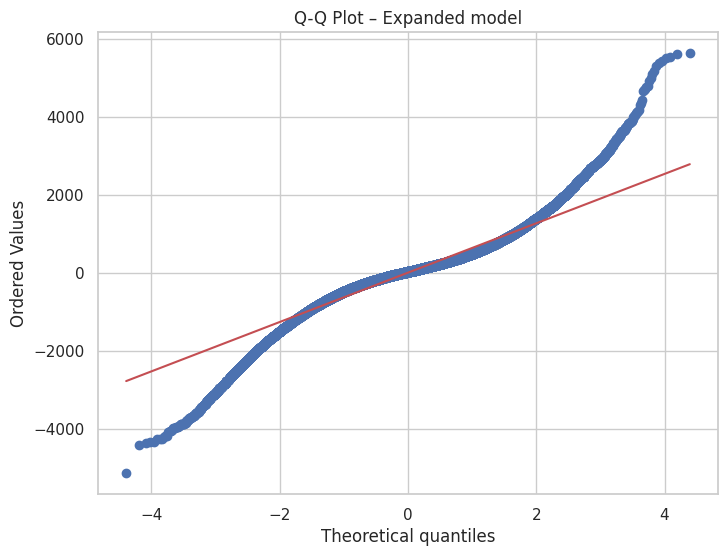

{'JB statistic': np.float64(109355.9558123331), 'p-value': np.float64(0.0), 'skew': np.float64(-0.18893455355597166), 'kurtosis': np.float64(7.566404146148525)}


In [ ]:
# Expanded Model Residuals
residuals_expanded = model_expanded.resid

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals_expanded, dist="norm", plot=plt)
plt.title("Q-Q Plot – Expanded model")
plt.show()

# Jarque–Bera test
# H0: residuals are normally distributed
jb_test_expanded = jarque_bera(residuals_expanded)
labels = ["JB statistic", "p-value", "skew", "kurtosis"]

print(dict(zip(labels, jb_test_expanded)))



**Expanded Model - Normality of Residuals**  

- The Q-Q plot and Jarque-Bera test (p ≈ 0.000) confirm **persistent non-normality**.
- No visible improvement compared to the baseline model.

Although the addition of predictors increases explanatory power but does not resolve the issue of heavy-tailed residuals.

##### **C. Comparison of Results**

Both models **violate the normality assumption**.
Residuals show leptokurtic behavior (heavy tails) and mild skewness, as confirmed by the Jarque-Bera test (p-value ≈ 0.000 in both cases).
The models' residuals are **not perfectly normal**, indicating the presence of occasional extreme deviations in debt levels.
Nevertheless, the use of HC3 robust errors ensures reliable inference despite this violation.

#### 4.3.4 Multicollinearity  

We will now check whether there is multicollinearity among the independent variables.  
Multicollinearity does not affect the overall explanatory power ($R^2$), but it makes the interpretation of individual coefficients more difficult, since it becomes harder to isolate the effect of each independent variable on the dependent one.  

To detect multicollinearity, we use the **Variance Inflation Factor (VIF):**  
- **VIF > 10** indicates severe multicollinearity.  
- **5 < VIF < 10** may already be problematic.  




##### **A. Baseline Model**  

For the baseline model, it does not make sense to study multicollinearity, since it only includes one independent variable (`income`).  
Therefore, the analysis of multicollinearity will only be relevant for the **expanded model**.  


##### **B. Expanded Model**


In [ ]:
# Independent Variables Matrix (Expanded Model)
X_expanded = model_expanded.model.exog

# VIF Calculation
vif_expanded = pd.DataFrame()
vif_expanded["Feature"] = model_expanded.model.exog_names
vif_expanded["VIF"] = [variance_inflation_factor(X_expanded, i) for i in range(X_expanded.shape[1])]

print(vif_expanded)



                    Feature         VIF
0                 Intercept  149.072752
1   C(occupancy_type)[T.pr]    1.523977
2   C(occupancy_type)[T.sr]    1.418391
3     C(loan_type)[T.type2]    1.462829
4     C(loan_type)[T.type3]    1.127027
5     C(loan_purpose)[T.p2]    1.108624
6     C(loan_purpose)[T.p3]    1.765157
7     C(loan_purpose)[T.p4]    1.816572
8                    income    1.809200
9               loan_amount    1.944139
10         rate_of_interest    2.542780
11     interest_rate_spread    2.970918
12                     term    1.450583
13                   status    1.186976


**Expanded Model - Multicollinearity**  

The VIF analysis shows that all independent variables present low values (all < 5).  
This indicates that **no problematic multicollinearity** exists among the explanatory variables in the expanded model.  
The high value of the intercept is not a concern, as it results from scaling and does not affect the interpretation of multicollinearity.  
Since the multicollinearity assumption is not violated, the coefficients can be interpreted reliably.  



#### 4.3.5 Independence of Errors (Autocorrelation of Residuals)  

The study of **independence of errors** is important to verify whether residuals are autocorrelated.  
Autocorrelation means that the error of one observation is associated with the error of another, which compromises the validity of statistical inference.  

The **Durbin-Watson test** was used to check this condition.  
Values between **1.5 and 2.5** are considered acceptable, indicating the absence of residual autocorrelation.  



In [ ]:
# Baseline Model Residuals
residuals_base = model_base.resid

# Durbin–Watson test
dw_test_base = durbin_watson(residuals_base)

# Expanded Model Residuals
residuals_expanded = model_expanded.resid

# Durbin–Watson test
dw_test_expanded = durbin_watson(residuals_expanded)

print(f"Durbin–Watson Test (Baseline model): {dw_test_base:.4f}")
print(f"Durbin–Watson Test (Expanded model): {dw_test_expanded:.4f}")


Durbin–Watson Test (Baseline model): 2.0107
Durbin–Watson Test (Expanded model): 2.0138


**Comparison of Results**  

Durbin-Watson test values:  
- **Baseline model:** 2.0107  
- **Expanded model:** 2.0138  

Both values fall within the acceptable range (1.5-2.5), indicating no residual autocorrelation.  
The independence of errors assumption is satisfied in both models.  





### 4.4 Conclusion - Linear Regression Model  

The study developed for Method 2 compared the **baseline model** (`debt ~ income`) with the **expanded model**, which included additional loan variables and personal characteristics.  

The **baseline model** showed that `income` is highly significant and explains about **71% of debt variation**, confirming its relevance as a central determinant.  
The **expanded model** also confirmed the importance of `income`, although with less impact, and revealed statistical significance for additional variables (`loan_amount`, `rate_of_interest`, `status`, `loan_type`, `loan_purpose`). The explanatory power increased to **75.5%**.  

Regarding the model assumptions:  
- **Linearity:** satisfied in both models, with no relevant non-linear patterns.  
- **Independence of errors:** satisfied, with Durbin-Watson values close to 2.  
- **Multicollinearity:** absent in the expanded model (low VIF values).  
- **Homoscedasticity:** violated in both models (Breusch-Pagan p-value ≈ 0.000), implying unreliable standard errors without correction.  
- **Normality of residuals:** not satisfied, due to heavy tails and rejection of the Jarque-Bera test.  

In summary, the **expanded model improves the statistical fit**, although both models violate the assumptions of homoscedasticity and normality of residuals.  
To mitigate these issues, we applied **robust standard errors (HC3)**, ensuring that statistical inference remains valid.  

Thus, we conclude that **`income` is a key determinant of `debt`**, but additional factors related to loan conditions and borrower characteristics also contribute to a more complete and realistic model.  




# 5  Method 2 - Two-Sample t-Test: The Effect of Creditworthiness on Income

### 5.1  Why this method?

We apply a two-sample t-test to compare `income` across `creditworthiness` groups because it is simple, interpretable, and directly addresses whether borrower composition differs between l1 and l2.

As a first step, we test whether the average `income` differs between l1 (higher creditworthiness) and l2 (lower creditworthiness). This provides a clear, inferential check on group composition: if `incomes` differ, part of any `debt` gap could reflect `income` differences rather than `creditworthiness` alone.

Given that financial data often have unequal variances and unbalanced group sizes, we use Welch’s t-test, which does not assume equal variances. We then assess robustness by inspecting key assumptions (approximate normality at large n and independence of observations).

This `income` comparison complements the regression analysis: the regression quantifies the `income` → `debt` relationship, while the Welch test establishes whether `income` itself is distributed differently by `creditworthiness`. Together, they help distinguish composition effects (income differences between groups) from `creditworthiness` effects (differences beyond income).



### 5.2  Assumptions

In the dataset, borrower `credit worthiness` is coded as l1 and l2 without explicit labels. To interpret these categories, we use the average interest rate paid by each group as an empirical proxy for credit risk: the group with a higher typical interest rate is more likely to reflect riskier (subprime) borrowers, while the lower-rate group reflects prime borrowers. This approach aligns with standard lending practice, where higher perceived default risk is compensated with higher interest.

Variables: `Credit_Worthiness` and `rate_of_interest`.

Average interest rate by group:

l1: 4.03% (median 3.99%, n = 107,915)

l2: 4.48% (median 4.38%, n = 4,316)

l2 has the higher average interest rate (≈ 4.48% vs 4.03%), so it is the better candidate for subprime, and l1 for prime.

#### 5.2.1  Normality test (Shapiro–Wilk and QQ-plots)

We use the Shapiro–Wilk test on each group and draw QQ-plots. For very large samples (n>5,000), we randomly subsample to the Shapiro limit so the test runs. If p<0.05 or the QQ-plot shows curved tails, we note deviations from normality. (With large n the t-test is robust, but we also provide a non-parametric robustness check later.)

n_L1 = 119763, n_L2 = 5246
Income • L1: Shapiro–Wilk W = 0.9189, p = 9.3e-46  (n used = 5000, total n = 119763)


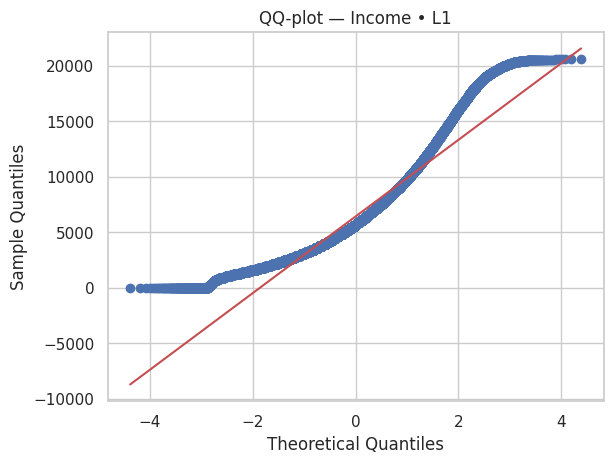

Income • L2: Shapiro–Wilk W = 0.9258, p = 2.527e-44  (n used = 5000, total n = 5246)


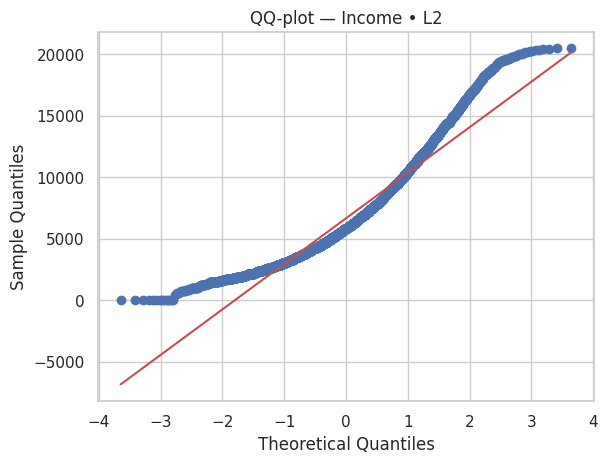

Levene (Brown–Forsythe): W = 41.751, p = 0.0000
Equal variances assumption: False → use Welch’s t


In [ ]:
cw_col = "credit_worthiness"

# Make sure the column exists and standardize to 'L1'/'L2'
df_final[cw_col] = (
    df_final[cw_col]
      .astype(str).str.strip().str.upper()
      .str.replace(r"\s+", "", regex=True)
)

# Build group arrays for income
inc_I1 = pd.to_numeric(
    df_final.loc[df_final[cw_col] == "L1", "income"], errors="coerce"
).dropna().astype(float).values

inc_I2 = pd.to_numeric(
    df_final.loc[df_final[cw_col] == "L2", "income"], errors="coerce"
).dropna().astype(float).values

print(f"n_L1 = {inc_I1.size}, n_L2 = {inc_I2.size}")

#1) Shapiro–Wilk + QQ per group
def shapiro_and_qq(x, label, seed=0):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size

    # Shapiro–Wilk defined up to n=5000 → subsample if needed
    if n > 5000:
        rng = np.random.default_rng(seed)
        x_test = rng.choice(x, size=5000, replace=False)
    else:
        x_test = x

    W, p = stats.shapiro(x_test)
    print(f"{label}: Shapiro–Wilk W = {W:.4f}, p = {p:.4g}  (n used = {x_test.size}, total n = {n})")

    # QQ-plot
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"QQ-plot — {label}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

# Run per group
shapiro_and_qq(inc_I1, "Income • L1")
shapiro_and_qq(inc_I2, "Income • L2")

#2) Equality of variances: Levene
W, p = stats.levene(inc_I1, inc_I2, center="median")
print(f"Levene (Brown–Forsythe): W = {W:.3f}, p = {p:.4f}")
print("Equal variances assumption:", p >= 0.05, "→ use", "Student’s t" if p >= 0.05 else "Welch’s t")



Shapiro–Wilk indicates departures from normality for both groups:
L1: W = 0.9189, p ≈ 9.3×10⁻⁴⁶ (n used = 5,000; total n = 119,763).
L2: W = 0.9258, p ≈ 2.53×10⁻⁴⁴ (n used = 5,000; total n = 5,246).
QQ-plots show right-skew/heavy tails in both groups. With very large samples, the t-test is robust to such deviations; we therefore proceed and also report a non-parametric robustness check.

Levene (Brown–Forsythe, median-centered): W = 41.751, p < 0.001 → variances are unequal.
Therefore we use Welch’s two-sample t-test (unequal variances).

#### 5.2.2  Equality of Variances (Levene Test)

### 5.3  Model

#### 5.3.1 t-test (Credit Worthiness ~ Debt)

**What this test measures**

We compare mean income between the two creditworthiness groups (L1 and L2) using a Welch two-sample t-test. This shows whether households with lower creditworthiness (L2) have different average incomes than higher-credit households (L1), helping interpret any downstream differences we see elsewhere.

Assumption check used: Levene (Brown–Forsythe) indicated unequal variances, so Welch’s version is appropriate.

Hypotheses (one-sided):

H₀: μₗ₂ = μₗ₁ (no higher mean income in L2)

H₁: μₗ₂ > μₗ₁

For the Welch two-sample t-test, we present the group sample sizes (n) and their means ± standard deviations (SD) to describe the data distributions in each creditworthiness category.
The mean difference (L2 − L1) quantifies the actual gap in average income between the two groups.

The Welch t-statistic and its corresponding degrees of freedom (df) indicate the magnitude of the difference relative to within-group variability, accounting for unequal variances and sample sizes.

The one-sided p-value tests the directional hypothesis that L2’s mean income is greater than L1’s.

The 95% confidence interval (CI) for the mean difference shows the range of plausible values.

Finally, the effect size (Hedges’ g) standardizes the mean difference relative to pooled variability, allowing us to interpret its practical significance—that is, whether the difference is large enough to be meaningful beyond mere statistical significance.

A significant result supports that L2 has higher mean income than L1 (in your direction); a non-significant result suggests no evidence that L2’s mean income exceeds L1’s.

In [ ]:
# 1) Group descriptives
n1, n2 = len(inc_I1), len(inc_I2)
m1, m2 = np.mean(inc_I1), np.mean(inc_I2)
s1, s2 = np.std(inc_I1, ddof=1), np.std(inc_I2, ddof=1)

desc = pd.DataFrame({
    "Group": ["L1", "L2"],
    "n": [n1, n2],
    "Mean": [m1, m2],
    "SD": [s1, s2],
    "Mean ± SD": [f"{m1:.2f} ± {s1:.2f}", f"{m2:.2f} ± {s2:.2f}"]
})
print("Descriptives (Income):")
display(desc)

# 2) Welch t-test (unequal variances)
t_two, p_two = stats.ttest_ind(inc_I2, inc_I1, equal_var=False)
# Welch-Satterthwaite df
v1, v2 = s1**2, s2**2
se = np.sqrt(v1/n1 + v2/n2)
df_welch = (v1/n1 + v2/n2)**2 / ((v1**2)/((n1**2)*(n1-1)) + (v2**2)/((n2**2)*(n2-1)))

# 95% CI for mean difference (L2 - L1)
mdiff = m2 - m1
tcrit = stats.t.ppf(0.975, df_welch)
ci_lo, ci_hi = mdiff - tcrit*se, mdiff + tcrit*se

# One-sided p-value for H1: mu_L2 > mu_L1
p_one = p_two/2 if t_two > 0 else 1 - p_two/2

# 3) Effect size: Hedges' g (bias-corrected Cohen's d)
sp2 = ((n1-1)*v1 + (n2-1)*v2) / (n1+n2-2)  # pooled variance
sp = np.sqrt(sp2)
d = (m2 - m1) / sp
J = 1 - (3/(4*(n1+n2)-9))
g = J * d

print("\nWelch two-sample t-test (Income: L2 - L1):")
print(f"t = {t_two:.3f}, df = {df_welch:.1f}, p(two-sided) = {p_two:.4g}, p(one-sided L2>L1) = {p_one:.4g}")
print(f"Mean difference (L2 - L1) = {mdiff:.2f}")
print(f"95% CI (Welch) for difference: [{ci_lo:.2f}, {ci_hi:.2f}]")
print(f"Hedges' g = {g:.3f}  (Cohen's d = {d:.3f})")


Descriptives (Income):


,Group,n,Mean,SD,Mean ± SD
0,L1,119763,6408.260349,3588.805216,6408.26 ± 3588.81
1,L2,5246,6652.388382,3844.204545,6652.39 ± 3844.20



Welch two-sample t-test (Income: L2 - L1):
t = 4.514, df = 5652.8, p(two-sided) = 6.482e-06, p(one-sided L2>L1) = 3.241e-06
Mean difference (L2 - L1) = 244.13
95% CI (Welch) for difference: [138.11, 350.14]
Hedges' g = 0.068  (Cohen's d = 0.068)


L2’s mean income is slightly higher than L1’s (t(5652.8) = 4.51, p < 0.001, g = 0.07), but the practical difference is small. While the test result is statistically significant due to large sample sizes, the effect size indicates only a modest real-world gap—about 3.8% higher income for L2. To ensure robustness, a non-parametric Mann–Whitney U test was also conducted and confirmed the same direction of results, reinforcing that the observed difference is reliable, though limited in magnitude.

#### 5.3.2  Visualization

In [ ]:
# 1) Find the credit worthiness column
cw_col = next(c for c in df_final.columns if "credit" in c.lower() and "worth" in c.lower())

# 2) Build plotting frame
df_plot = df_final[[cw_col, "income"]].copy()
df_plot[cw_col] = df_plot[cw_col].astype(str).str.strip().str.lower()
df_plot = df_plot[df_plot[cw_col].isin(["l1", "l2"])]
df_plot["income"] = pd.to_numeric(df_plot["income"], errors="coerce")
df_plot = df_plot.dropna(subset=["income"])

# 3) Plotly violin
fig = px.violin(
    df_plot,
    x=cw_col,
    y="income",
    color=cw_col,
    category_orders={cw_col: ["l1", "l2"]},
    color_discrete_map={"l1": "#1f77b4", "l2": "#d62728"},
    box=True,
    points=False
)

fig.update_layout(
    title="Income by Creditworthiness (L1 vs L2)",
    xaxis_title="Creditworthiness",
    yaxis_title="Income",
    showlegend=False
)

fig.show()



The `income` violins show right-skewed distributions for both groups, with l2 shifted slightly to the right: its **median** (≈5,820) and upper tail are a bit higher than l1 (**median** ≈5,640). This visual aligns with our Welch t-test, which found a small but significant income difference (l2 > l1), indicating modest composition differences across `creditworthiness` groups.

### 5.4  Results

Before running the t-test, assumption checks were conducted.
Shapiro–Wilk tests (Wₗ₁ = 0.9189, p < 0.001; Wₗ₂ = 0.9258, p < 0.001) and QQ-plots indicated slight right-skewness in both `income` distributions. Given the large sample sizes, these deviations from normality are not problematic.
Levene’s test (Brown–Forsythe) showed unequal variances between groups (W = 41.75, p < 0.001), so Welch’s t-test was used.

The Welch two-sample t-test comparing mean `income` between `creditworthiness` groups found a statistically significant difference in favor of L2:
t(5652.8) = 4.514, p(one-sided) = 3.24×10⁻⁶.
Mean `income` was $6,408 ± 3,589 for L1 (n = 119,763) and $6,652 ± 3,844 for L2 (n = 5,246), a mean difference of $244 (95% CI [$138, $350]).
The effect size was small (Hedges’ g = 0.07), and a Mann–Whitney U test confirmed the same directional difference (p < 0.001)..

### 5.5  Interpretation

The tests show a statistically significant but modest `income` difference between `creditworthiness` groups, with L2 households reporting about 3.8% higher mean income than L1.
The small effect size suggests that, although statistically significant, the magnitude of this difference is limited in practical terms.
In Method 1, `income` was shown to be a strong predictor of `debt` (β ≈ 0.3099, R² ≈ 0.713).
Together, these results imply that income differences partially explain debt disparities between `creditworthiness` groups, but additional factors linked to `creditworthiness` contribute to the remaining variation in `debt` beyond `income`.

### 5.6  Conclusion

Welch’s two-sample t-test and robustness checks (normality, Levene, and Mann–Whitney) collectively show that L2 households have significantly higher mean `income` than L1 (p < 0.001).
However, the difference is small (g = 0.07, ≈3.8%), suggesting that while `income` plays a role, it does not fully account for `debt` variation across `creditworthiness` levels.
This supports the broader conclusion that `creditworthiness` adds explanatory power beyond `income` alone, consistent with the regression findings from Method 1.


---


# Reflection on the Use of AI

## How we used GenAI
We used GenAI as a practical assistant, not as an oracle. The main areas were:
- **Idea generation for methods and model selection.** We asked for options (e.g., OLS, Assumption tests, when to log-transform, how to compare clusters) and then narrowed them down ourselves.
- **Code generation** for common tasks (descriptive statistics, visualizations, regression formulas, CV (documentation left out in this assigment as already mentioned), clustering baselines).
- **Code commenting and explanation.** We asked for short, clear comments and quick reminders of why a certain function or parameter is used.
- **Refining interpretations.** We drafted findings and asked GenAI to help tighten the wording so it reads clearly and stays tied to the numbers.

## What we added as a team
- **Peer review and discussion.** We met weekly (in person and online) and also discussed ideas in chat between meetings. GenAI helped us sketch broad ideas; then we challenged them, cut what didn’t fit, and kept what did (what rhymes is true).
- **Filtering and decisions.** Many GenAI suggestions were rejected after individual checks or group review. We often kept the general shape of an approach but changed details to fit our data and hypothesis.
- **Turning instructions into working code.** We used GenAI to draft the first version, then manually adapted it to the assignment (e.g. column names, runtime constraints). Often this was a step-by-step loop:

  *generate → run → fix → retest*
- **Quality control.** We checked outputs against expectations, looked at diagnostics, and adjusted for instance thresholds.

## Limitations we saw (and why this was acceptable here)
- **Training-bound outputs.** GenAI relies on patterns from existing code and documentation. That means the code it produces often resembles ideas already “out there.” If a method is uncommon or not well-represented in training data, it’s unlikely to show up in the suggestions.
- **Limited novelty.** Because of that, the output is rarely “new”. We mostly adapted and combined known techniques to our setting rather than inventing new ones. For this assignment, that was fine: our goal was to apply and compare sound methods based on our lecture, not to create new algorithms.
- **We mitigated this** by reviewing every step, rejecting or reshaping suggestions, and making sure the final pipeline matched our data, our assumptions, and the course goals. The benefit (faster iteration and more time for analysis) outweighed the risk.

---

## Examples (Prompts and Uses)

| Use Case | Prompt Example | Gen AI model |
|---|---|---|
| Code for Visualizations | “Plot Pearson/Spearman heatmaps for `income` vs `debt` and annotate N and p-values.” | ChatGPT 5 (OpenAI) |
| Code for Visualizations | “Plot `income` vs `debt` with k=3 clusters (K-Means and Hierarchical) side by side.” | ChatGPT 5 (OpenAI) |
| Code Generation for Testing | “Show first 50 rows of `income`, `dtir1`, `debt` only.” | ChatGPT 5 (OpenAI) |
| Code Generation for Testing | “Compute elbow (K-Means inertia) and silhouette (K-Means + Ward) on `income`/`debt`.” | ChatGPT 5 (OpenAI) |
| Code Generation/Adjustment for Statistics | “Add `debt` to `df_final` as `(dtir1/100) * income`.” | ChatGPT 5 (OpenAI) |
| Code Generation/Adjustment for Statistics | “Change model to `debt ~ income`, fit OLS (HC3), print R² + summary.” | ChatGPT 5 (OpenAI) |
| Code Generation/Adjustment for Statistics | “Run CV feature selection for `debt` with numeric + categorical vars; keep runtime reasonable.” | ChatGPT 5 (OpenAI) |
| Code Generation/Adjustment for Statistics | “Build OLS with only important predictors; wrap categoricals in `C()`; use HC3.” | ChatGPT 5 (OpenAI) |
| Error Fixing | “Fix `TypeError: string[python]` by casting categoricals and dropping missing rows before OLS.” | ChatGPT 5 (OpenAI) |
| Formatting | “Rewrite this interpretation as concise Markdown consistent with the following results: [...].” | ChatGPT 5 (OpenAI) |


---

## To make it short
GenAI helped us move faster from idea to testable code. The real work was deciding what to try, why it fits our case, and how to judge the results.


# 7 Conclusion

**Overall Findings**

income clearly emerges as the primary determinant of household debt in this dataset.

The baseline OLS model:
debt = 393.6 + 0.3099 * income + e



shows a strong, positive, and highly significant relationship: each additional unit of income increases debt by approximately 0.31 units (95% CI [0.309, 0.311], p < 0.001).
income alone explains roughly 71.3% (R² ≈ 0.713) of the variation in household debt—an exceptionally high explanatory power for a single-variable model.

The expanded model, which adds loan-specific and borrower-related features (e.g., loan_amount, rate_of_interest, interest_rate_spread, term, occupancy_type, loan_purpose), improves explanatory power to R² ≈ 0.76.
This confirms that while income remains the dominant driver (β = 0.2582, p < 0.001), other characteristics meaningfully contribute to explaining variation in debt.
Taken together, the results demonstrate that household debt is multifactorial, with income as the central but not exclusive driver.

Complementing this regression analysis, a Welch two-sample t-test comparing mean income across creditworthiness groups shows that households in L2 earn slightly more on average than those in L1.
Mean income is 6,652 ± 3,844 for L2 and 6,408 ± 3,589 for L1, yielding a mean difference of 244 (95% CI [138, 350]).
This difference is statistically significant (t(5652.8) = 4.514, p(one-sided) < 0.001) but practically small (Hedges’ g = 0.07).
The finding implies that while part of the L2–L1 debt gap can be attributed to income, creditworthiness likely captures additional behavioral and financial dimensions—such as access to credit, repayment behavior, or risk-based pricing—that further explain variation in debt.

Together, these findings suggest that:

income differences explain a large share of debt variation (≈ 71–76%), confirming its foundational role.

creditworthiness adds explanatory power beyond income, capturing risk and access factors that income alone cannot.

The observed income gap (~3.8%) is statistically significant but economically modest, meaning the real-world difference in financial capacity between credit groups is relatively small.

**Practical Implications**

For lenders, credit analysts, and policymakers, this analysis reinforces that income should remain a key factor for determining borrowing limits and affordability assessments.
However, integrating creditworthiness indicators (such as credit scores or delinquency history) provides a more complete view of financial behavior.
Segmenting borrowers by creditworthiness can refine lending strategies and improve risk-based decision-making, as it accounts for differences that income alone does not capture.

**Limitations and Next Steps**

The analysis is cross-sectional and does not imply causality.
The t-test compares group means but does not test whether the slope of the income–debt relationship differs across creditworthiness groups.
Future work should:

Expand to multiple regression models with interaction terms (income * creditworthiness) to test for moderation effects.

Report ΔR² values to quantify the incremental explanatory power of added variables.

Explore quantile and nonlinear regression to examine whether the income–debt relationship varies across the income distribution.

Conduct robustness checks (e.g., Mann–Whitney U or bootstrap resampling) to confirm that results hold under non-parametric assumptions.

If timestamped data become available, apply panel or time-series regression to assess temporal stability and causal direction in the income–debt link.

# References

- Chikeya, C.K., & Ntsalaze, L. (2025). Open Access Review: *Determinants of Household Debt: A Systematic Review of the Literature.*  
  Johannesburg Business School, University of Johannesburg, Johannesburg 2092, South Africa;  
  College for Business & Economics, University of Johannesburg, Johannesburg 2092, South Africa.  
  Economies, 13(3), 76. https://doi.org/10.3390/economies13030076  

- Calcagnini, G., Favaretto, F., Giombini, G., & Tramontana, F. (2025). *Household Financial Fragility, Debt and Income in a Dynamic Model.*  
  Computational Economics, 65, 963–988. Published 14 Aug 2024.  
  https://doi.org/10.1007/s10614-024-10698-y  

- Brown, M., Stein, S., & Zafar, B. (2013). *The Impact of Housing Markets on Consumer Debt: Credit Report Evidence from 1999 to 2012.*  
  Federal Reserve Bank of New York, Staff Report No. 617, May 2013 (Revised Sept 2013).  
  https://www.newyorkfed.org/medialibrary/media/research/staff_reports/sr617.pdf  
